In [3]:
# loading
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors  
from rdkit.Chem import Lipinski
from rdkit import DataStructs
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

#import pubchempy as pcp
#from IPython.display import Imag

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn import metrics
#from sklearn.ensemble import RandomForestRegressor

#import torch
from scipy import stats
from scipy.stats import pearsonr
import os

import joblib
import json

from openbabel import pybel

from itertools import chain


In [2]:
## Remove data column with std=0
def clean_std(df):
    print('Before clean', df.shape )
    #X_features.loc[ :, X_features.std() > X_features.mean() ]
    df_new = df.loc[ :, df.std()>0 ]
    print('After clean', df_new.shape )
    return df_new

# Remove high correlated data, step by step
def remove_high_corr_gradually(df, cutoff=0.9, highlight=None):
    corr_matx = df.corr()
    #sns.heatmap(corr_matx.abs())
    # The upper triangle of absolute values
    upper_tri = corr_matx.abs().where(np.triu(np.ones(corr_matx.shape),k=1).astype(bool))
    upper_tri = upper_tri>cutoff
    
    for n in range(len(upper_tri)):
        if upper_tri.sum().sum()>0:
            ## Find which one has the most overlap 
            occur = upper_tri.sum(axis=0).add( upper_tri.sum(axis=1) ).sort_values(ascending=False)
            bad_fp = list( occur.index )[0]
            #print( bad_fp, occur[bad_fp])
            upper_tri.drop( bad_fp, axis=1, inplace=True)
            upper_tri.drop( bad_fp, axis=0, inplace=True)
        else:
            break
    
    print("Num of keep: ",len(upper_tri.columns))
    print("Num of drop: ",len(df.columns)-len(upper_tri.columns))
    print("---------")
    
    if highlight is not None:
        highlight = corr_matx[ highlight ]
        
    return  df[ upper_tri.columns ], highlight

## Standardization of a pd dataframe
def get_std(data_x):   
    scaler = StandardScaler()
    scaler.fit(data_x)
    X_scale = scaler.transform(data_x)
    data_new = pd.DataFrame(X_scale, columns=data_x.columns, index=data_x.index)
    return data_new, scaler  ## Save the new data, and its scaler

# Standardization of a dict of pd dataframe
def standard_dataset(dataset_dict):
    dataset_new = dataset_dict.copy()
    x_train, scaler = get_std(dataset_dict['x_train'])
    x_test = scaler.transform(dataset_dict['x_test'])
    x_test = pd.DataFrame(x_test, columns=dataset_dict['x_test'].columns, index=dataset_dict['x_test'].index)
    x_val = scaler.transform(dataset_dict['x_val'])
    x_val = pd.DataFrame(x_val, columns=dataset_dict['x_val'].columns, index=dataset_dict['x_val'].index)
    dataset_new['x_train'] = x_train
    dataset_new['x_test'] = x_test
    dataset_new['x_val'] = x_val
    dataset_new['scaler'] = scaler
    return dataset_new

## split train, text, valid
def split_data(x,y, rand_state=0):
    # Assign 20% data as testing data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state =rand_state, shuffle = True)
    # Assign 20% data as val data, so train data is 60%.  val size = 0.8*0.125 = 0.1
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=rand_state)    
    print("Train, Test, Val sizes are: ", x_train.shape, x_test.shape, x_val.shape)

    return  x_train, x_test, x_val, y_train, y_test, y_val

## Call lazypredictor
from lazypredict.Supervised import LazyRegressor

def do_lazy_regression(data_dict, ylabel=None, rg="all"):
    reg = LazyRegressor(verbose=2,ignore_warnings=False, custom_metric=None, regressors=rg)
    if ylabel is not None:
        models,predictions = reg.fit(data_dict['x_train'], data_dict['x_test'], data_dict['y_train'][ylabel], data_dict['y_test'][ylabel])
    else:
        models,predictions = reg.fit(data_dict['x_train'], data_dict['x_test'], data_dict['y_train'], data_dict['y_test'])
    return models, predictions

def know_any_depth(x_train, y_train, x_test, y_test, model_algorithm, name='None', max_layer=20, vb=0):
    values = [i for i in range(1, max_layer)]  ## depth of tree
    train_scores, test_scores =[], []
    r2_train,rmse_train,r2_test,rmse_test = [],[],[],[]
    # evaluate a decision tree for each depth
    for i in values:
        model = model_algorithm(max_depth=i, verbose=vb)
        model.fit(x_train, y_train)
        y_pred_train=model.predict(x_train)
        y_pred_test=model.predict(x_test)
        r2_train.append( metrics.r2_score(y_train, y_pred_train) )
        rmse_train.append( metrics.mean_squared_error(y_train, y_pred_train, squared=False) )
        r2_test.append( metrics.r2_score(y_test, y_pred_test) )
        rmse_test.append( metrics.mean_squared_error(y_test, y_pred_test, squared=False) )
        # summarize progress
        print('>%d, train: %.3f, test: %.3f' % (i, r2_train[-1], r2_test[-1]))
    # plot of train and test scores vs tree depth
    fig, axs = plt.subplots(1,2,figsize=(12,6),tight_layout=True)
    axs[0].plot(values, r2_train, '-o', label='Train')
    axs[0].plot(values, r2_test, '-o', label='Test')
    axs[0].set_xticks( np.arange(1,max_layer+1,1) )
    axs[0].grid(axis='both',color='g')
    axs[0].legend()
    axs[0].set_title('R2')
    axs[1].plot(values, rmse_train, '-o', label='Train')
    axs[1].plot(values, rmse_test, '-o', label='Test')
    axs[1].set_xticks( np.arange(1,max_layer+1,1) )
    axs[1].grid(axis='both',color='g')
    axs[1].legend()
    axs[1].set_title('RMSE')
    #pyplot.savefig("testtrain90-10.png", dpi=300)
    plt.show()
    print("=============Done==============")
    
def model_any_fit(x_train,y_train, x_test,y_test, model_algorithm, name='None', axs_lim=None,savefig=None, ml_parameter=None):
    if ml_parameter is None:
        model = model_algorithm( )
    else:
        model = model_algorithm(**ml_parameter)
    model = model.fit(x_train, y_train)
    y_pred_train=model.predict(x_train)
    y_pred_test=model.predict(x_test)

    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))    
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)

    print("================ Info =================")
    print(">>>>>> Train set", x_train.shape)
    print("R square score: " , r2_train)
    print("RMSE, MAE: ", rmse_train, mae_train)
    print(">>>>>> Test set", x_test.shape)
    print("R square score: " , r2_test)
    print("RMSE, MAE: ", rmse_test, mae_test)
    
    fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True)
    axs.plot(y_train, y_pred_train, 'o', color='orange', label='Training',alpha=0.8, markersize=5)           # scatter plot showing actual data
    axs.plot(y_test, y_pred_test, 'v', color='g', label='Testing',alpha=0.2, markersize=3)           # scatter plot showing actual data
    axs.plot([-100,100], [-100,100], '--', color='k') 

    a_train, b_train = np.polyfit(y_train, y_pred_train, 1)
    a_test, b_test = np.polyfit(y_test, y_pred_test, 1)
    if axs_lim is None:
        ax_min = np.amin([np.amin(y_train), np.amin(y_test)])-0.3
        ax_max = np.amax([np.amax(y_train), np.amax(y_test)])+0.3
        axs.set_xlim((ax_min,ax_max))
        axs.set_ylim((ax_min,ax_max))
    else:
        axs.set_xlim(axs_lim)
        axs.set_ylim(axs_lim)

    axs.set_xlabel('Reference ',fontsize=10) ## input X name
    axs.set_ylabel('ML prediction',fontsize=10) ## input Y name
    axs.tick_params(direction='in',labelsize=8)
    
    axs.legend(fontsize=8, frameon=False,)
    plt.title(name)
        
    r2_train, rmse_train, mae_train, r2_test, rmse_test, mae_test = np.round([r2_train,rmse_train,mae_train,r2_test,rmse_test,mae_test], 2)
    performance_train = f'R$^2$: {r2_train}\nRMSE: {rmse_train}\nMAE: {mae_train}'
    performance_test = f'R$^2$: {r2_test}\nRMSE: {rmse_test}\nMAE: {mae_test}'
    axs.text(0.65,0.25, performance_train, style='italic', fontsize=10, transform = axs.transAxes, backgroundcolor='white',color='orange')
    axs.text(0.65,0.05, performance_test,  style='italic', fontsize=10, transform = axs.transAxes, backgroundcolor='white',color='g')

    if savefig is not None:
        plt.savefig(savefig, dpi=800)
    plt.show()
    return model

## Evaluate validation data
def score_val(x_val, y_val, model, name='',axs_lim=None, savefig=None, alpha=0.5):
    y_predict_val = model.predict(x_val)
    
    fig, axs = plt.subplots(1,1,figsize=(3.,3.),tight_layout=True )#,dpi=100)
    #axs.plot(y_val, y_predict_val, 'o', color='r',label='Validating')  
    
    x,y,z = color_density(y_val, y_predict_val)
    #z = plt.cm.jet(z)            
    im = axs.scatter(x, y, marker='o', c=z, cmap='jet', label='Validating', alpha=alpha, s=10) 
    
    axs.plot([-100,100], [-100,100], '--', color='k', lw=1)
    
    a, b = np.polyfit(y_val, y_predict_val, 1)
    #axs.plot(y_val, a*y_val+b, color='r') 
    
    r2_val, _ = stats.pearsonr( y_val, y_predict_val )
    #r2_val = metrics.r2_score(y_val, y_predict_val)
    rmse_val = np.sqrt(metrics.mean_squared_error(y_val, y_predict_val))    
    mae_val = metrics.mean_absolute_error(y_val, y_predict_val)
    print(">>>>>> Val set", y_val.shape)
    print("R square score: " , r2_val)
    print("RMSE, MAE:", rmse_val, mae_val)
    
    #plt.text(-11,-6.5, 'R^2 = 0.811')
    if axs_lim is None:
        ax_min = np.amin([np.amin(y_val), np.amin(y_predict_val)])-0.1
        ax_max = np.amax([np.amax(y_val), np.amax(y_predict_val)])+0.1
        axs.set_xlim((ax_min,ax_max))
        axs.set_ylim((ax_min,ax_max))
    else:
        axs.set_xlim(axs_lim)
        axs.set_ylim(axs_lim)
    
    axs.set_xlabel('DFT LUMO (eV) ',fontsize=10) ## input X name
    axs.set_ylabel('ML LUMO (eV)',fontsize=10) ## input Y name
    axs.tick_params(direction='in',labelsize=8)
    
    plt.title(name)
    #fig.colorbar(im, shrink=0.5, label='Density')

    r2_val, rmse_val, mae_val = np.round([r2_val, rmse_val, mae_val], 2)
    performance = f'R$^2$: {r2_val}\nRMSE: {rmse_val}\nMAE: {mae_val}'
    axs.text(0.6,0.05, performance, style='italic', fontsize=10, transform = axs.transAxes, backgroundcolor='white', color='k')
    
    #axs.legend(fontsize=8, frameon=False,)
    if savefig is not None:
        plt.savefig(savefig, dpi=800)      
    plt.show()
    
    return r2_val, rmse_val, mae_val
    
def color_density(x,y):
    x= np.array(x)
    y= np.array(y)
    xy = np.vstack([x, y])
    z = stats.gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    return x,y,z

def xyz_to_smiles(fname: str) -> str:
    mol = next(pybel.readfile("xyz", fname))
    smi = mol.write(format="smi")
    return smi.split()[0].strip()

def smiles_to_xyz_pybel(smi, if_write_xyz='molecule.xyz', if_overwrite=False):
    mol = pybel.readstring("smi", smi)
    mol.addh() # add Hs for 3D
    mol.make3D() # generate 3D coordinates
    if if_write_xyz is not None:
        xyz = mol.write(format='xyz',filename=if_write_xyz, overwrite=if_overwrite)
    else:
        xyz = mol.write(format='xyz')
    return xyz

In [3]:
import scipy.stats as stats

def see_correlation(df, xlabel, ylabel='LUMO', color=None):
    fig, axs = plt.subplots(1,1, figsize=(5,4),tight_layout=True)
    y= np.array(df[ylabel])
    x= np.array(df[xlabel])
    if color is None:
        xy = np.vstack([x, y])
        z = stats.gaussian_kde(xy)(xy)
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    else:
        z = color
    #z = plt.cm.jet(z) 
    
    correlation_coefficient = stats.pearsonr(x, y)[0]
    print(correlation_coefficient)

    im = axs.scatter( x,y, c=z, marker='o', cmap='jet',alpha=0.5, edgecolors='none', s=20)
    axs.set_ylabel(ylabel,fontsize=14) ## input X name
    axs.set_xlabel(xlabel,fontsize=14) ## input Y name
    axs.tick_params(direction='in',labelsize='10')
    plt.show()

# Read Structures

In [4]:
df_pnl = pd.read_csv('df_diene_final_dataset_passed.csv', index_col=0)
df_pnl

,LUMO,HOMO,source,diene_type,diene_class,Inchi,rdk_MaxAbsEStateIndex,rdk_MaxEStateIndex,rdk_MinAbsEStateIndex,rdk_MinEStateIndex,...,RingCount_3,RingCount_4,RingCount_5,RingCount_6,RingCount_7,RingCount_8,RingCount_9,RingCount_10,RingCount_11,tag
N#Cc1nnc(C#N)nn1,-4.55,-8.22,PNL,2_two,N4,InChI=1S/C4N6/c5-1-3-7-9-4(2-6)10-8-3,8.16,8.16,0.14,-0.14,...,0,0,0,1,0,0,0,0,0,passed
[H]C(=O)c1nnc(C#N)nn1,-4.30,-7.88,PNL,2_two,N4,InChI=1S/C4HN5O/c5-1-3-6-8-4(2-10)9-7-3/h2H,9.92,9.92,0.13,-0.15,...,0,0,0,1,0,0,0,0,0,passed
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N,-4.26,-8.12,PNL,0_three,C4,InChI=1S/C7H3N3/c8-4-2-1-3-7(5-9)6-10/h1-3H/b2-1+,8.17,8.17,0.01,-0.01,...,0,0,0,0,0,0,0,0,0,passed
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N,-4.21,-8.20,PNL,0_three,C4,InChI=1S/C7H3N3/c8-4-1-2-7(6-10)3-5-9/h1-3H/b2...,8.25,8.25,0.18,0.18,...,0,0,0,0,0,0,0,0,0,passed
[H]O[S@+]([O-])c1nnc(C#N)nn1,-4.19,-7.86,PNL,2_two,N4,InChI=1S/C3HN5O2S/c4-1-2-5-7-3(8-6-2)11(9)10/h...,10.22,10.22,0.24,-2.30,...,0,0,0,1,0,0,0,0,0,passed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
[H]C(=C(/OC([H])([H])[H])N([H])[H])/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H])[H],0.75,-3.55,PNL,0_three,C4,"InChI=1S/C7H14N2O/c1-9(2)6-4-5-7(8)10-3/h4-6H,...",5.33,5.33,0.41,0.41,...,0,0,0,0,0,0,0,0,0,passed
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])([H])[H])/C([H])=C(\[H])N([H])[H],0.77,-3.80,PNL,0_three,C4,"InChI=1S/C7H14N2/c1-7(9(2)3)5-4-6-8/h4-6H,8H2,...",5.13,5.13,1.19,1.19,...,0,0,0,0,0,0,0,0,0,passed
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H],0.83,-3.96,PNL,0_two,C4,"InChI=1S/C4H8N2/c5-3-1-2-4-6/h1-4H,5-6H2/b3-1+...",4.93,4.93,1.42,1.42,...,0,0,0,0,0,0,0,0,0,passed
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H])C([H])([H])[H])=C(/[H])N(C([H])([H])[H])C([H])([H])[H],0.98,-3.65,PNL,0_three,C4,InChI=1S/C9H18N2O/c1-10(2)8-6-7-9(12-5)11(3)4/...,5.11,5.11,0.84,0.84,...,0,0,0,0,0,0,0,0,0,passed


In [5]:
df = df_pnl['diene_type'].value_counts()
display( df )


diene_type
0_three    3231
1_three    1868
0_two       336
1_two       303
2_two        53
1_one        20
0_one        18
2_one        10
Name: count, dtype: int64

In [6]:
idx_for_unknown = []
dt = sorted( set(df_pnl['diene_type']) )
for t in dt:
    if 'three' in t:
        d = df_pnl[ df_pnl['diene_type']==t ]
        d = d.sample(frac=0.6,axis=0, random_state=1321)
        #n = int( 0.2*len(d) )
        idx_for_unknown += list(d.index)

df_pnl_unknown = df_pnl.loc[idx_for_unknown]
df_pnl = df_pnl.drop( idx_for_unknown, axis=0)
display(df_pnl, df_pnl_unknown)

,LUMO,HOMO,source,diene_type,diene_class,Inchi,rdk_MaxAbsEStateIndex,rdk_MaxEStateIndex,rdk_MinAbsEStateIndex,rdk_MinEStateIndex,...,RingCount_3,RingCount_4,RingCount_5,RingCount_6,RingCount_7,RingCount_8,RingCount_9,RingCount_10,RingCount_11,tag
N#Cc1nnc(C#N)nn1,-4.55,-8.22,PNL,2_two,N4,InChI=1S/C4N6/c5-1-3-7-9-4(2-6)10-8-3,8.16,8.16,0.14,-0.14,...,0,0,0,1,0,0,0,0,0,passed
[H]C(=O)c1nnc(C#N)nn1,-4.30,-7.88,PNL,2_two,N4,InChI=1S/C4HN5O/c5-1-3-6-8-4(2-10)9-7-3/h2H,9.92,9.92,0.13,-0.15,...,0,0,0,1,0,0,0,0,0,passed
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N,-4.21,-8.20,PNL,0_three,C4,InChI=1S/C7H3N3/c8-4-1-2-7(6-10)3-5-9/h1-3H/b2...,8.25,8.25,0.18,0.18,...,0,0,0,0,0,0,0,0,0,passed
[H]O[S@+]([O-])c1nnc(C#N)nn1,-4.19,-7.86,PNL,2_two,N4,InChI=1S/C3HN5O2S/c4-1-2-5-7-3(8-6-2)11(9)10/h...,10.22,10.22,0.24,-2.30,...,0,0,0,1,0,0,0,0,0,passed
[H]C(=O)c1nnc(C([H])=O)nn1,-4.16,-7.55,PNL,2_two,N4,InChI=1S/C4H2N4O2/c9-1-3-5-7-4(2-10)8-6-3/h1-2H,9.91,9.91,0.13,-0.13,...,0,0,0,1,0,0,0,0,0,passed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H])[H])=C(/[H])N(C([H])([H])[H])C([H])([H])[H],0.69,-3.77,PNL,0_two,C4,"InChI=1S/C8H16N2/c1-9(2)7-5-6-8-10(3)4/h5-8H,1...",2.00,2.00,2.00,2.00,...,0,0,0,0,0,0,0,0,0,passed
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H])[H])=C(/[H])N([H])[H],0.69,-3.88,PNL,0_two,C4,"InChI=1S/C6H12N2/c1-8(2)6-4-3-5-7/h3-6H,7H2,1-...",5.06,5.06,1.50,1.50,...,0,0,0,0,0,0,0,0,0,passed
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])([H])[H])/C([H])=C(\[H])N([H])[H],0.77,-3.80,PNL,0_three,C4,"InChI=1S/C7H14N2/c1-7(9(2)3)5-4-6-8/h4-6H,8H2,...",5.13,5.13,1.19,1.19,...,0,0,0,0,0,0,0,0,0,passed
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H],0.83,-3.96,PNL,0_two,C4,"InChI=1S/C4H8N2/c5-3-1-2-4-6/h1-4H,5-6H2/b3-1+...",4.93,4.93,1.42,1.42,...,0,0,0,0,0,0,0,0,0,passed


,LUMO,HOMO,source,diene_type,diene_class,Inchi,rdk_MaxAbsEStateIndex,rdk_MaxEStateIndex,rdk_MinAbsEStateIndex,rdk_MinEStateIndex,...,RingCount_3,RingCount_4,RingCount_5,RingCount_6,RingCount_7,RingCount_8,RingCount_9,RingCount_10,RingCount_11,tag
[H]C([H])=C(C#N)/C(=C(/[H])C([H])([H])[H])C([H])([H])[H],-1.85,-6.76,PNL,0_three,C4,"InChI=1S/C7H9N/c1-4-6(2)7(3)5-8/h4H,3H2,1-2H3/...",8.25,8.25,0.55,0.55,...,0,0,0,0,0,0,0,0,0,passed
[H]O[S@+]([O-])/C(=C(\OC([H])([H])[H])C([H])=C([H])[H])N(C([H])([H])[H])C([H])([H])[H],-1.26,-5.36,PNL,0_three,C4,InChI=1S/C7H13NO3S/c1-5-6(11-4)7(8(2)3)12(9)10...,10.78,10.78,0.20,-2.05,...,0,0,0,0,0,0,0,0,0,passed
[H]C([H])=C(SC([H])([H])[H])/C(OC([H])([H])[H])=C(\[H])N([H])[H],-0.33,-5.29,PNL,0_three,C4,"InChI=1S/C6H11NOS/c1-5(9-3)6(4-7)8-2/h4H,1,7H2...",5.20,5.20,0.64,0.64,...,0,0,0,0,0,0,0,0,0,passed
[H]O[S@+]([O-])C(=C([H])/C([H])=C(/[H])SC([H])([H])[H])[S@@+]([O-])O[H],-2.21,-6.76,PNL,0_three,C4,InChI=1S/C5H8O4S3/c1-10-4-2-3-5(11(6)7)12(8)9/...,10.38,10.38,0.42,-2.39,...,0,0,0,0,0,0,0,0,0,passed
[H]O/C([H])=C(/C(C([H])=O)=C([H])[H])[S@@+]([O-])O[H],-2.19,-6.79,PNL,0_three,C4,"InChI=1S/C5H6O4S/c1-4(2-6)5(3-7)10(8)9/h2-3,7H...",10.19,10.19,0.21,-2.35,...,0,0,0,0,0,0,0,0,0,passed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
[H]C1=C(N(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C(C#N)=C1C([H])([H])[H],-1.20,-5.33,PNL,1_three,C6,InChI=1S/C10H14N2/c1-8-6-10(12(2)3)5-4-9(8)7-1...,8.74,8.74,0.90,0.90,...,0,0,0,1,0,0,0,0,0,passed
[H]C1=C(N([H])[H])C([H])([H])C([H])([H])C(SC([H])([H])[H])=C1C#N,-1.43,-5.29,PNL,1_three,C6,InChI=1S/C8H10N2S/c1-11-8-3-2-7(10)4-6(8)5-9/h...,8.69,8.69,0.74,0.74,...,0,0,0,1,0,0,0,0,0,passed
[H]OC(=O)C1=C([H])C(N(C([H])([H])[H])C([H])([H])[H])=C(N([H])[H])C([H])([H])C1([H])[H],-1.25,-5.18,PNL,1_three,C6,InChI=1S/C9H14N2O2/c1-11(2)8-5-6(9(12)13)3-4-7...,10.68,10.68,0.43,-0.85,...,0,0,0,1,0,0,0,0,0,passed
[H]C(=O)C1=C(C#N)C(SC([H])([H])[H])=C([H])C([H])([H])C1([H])[H],-3.05,-6.18,PNL,1_three,C6,InChI=1S/C9H9NOS/c1-12-9-4-2-3-7(6-11)8(9)5-10...,10.55,10.55,0.56,0.56,...,0,0,0,1,0,0,0,0,0,passed


In [7]:
df1= df_pnl['diene_type'].value_counts()
df2= df_pnl_unknown['diene_type'].value_counts()
display( df1, df2 )

diene_type
0_three    1292
1_three     747
0_two       336
1_two       303
2_two        53
1_one        20
0_one        18
2_one        10
Name: count, dtype: int64

diene_type
0_three    1939
1_three    1121
Name: count, dtype: int64

In [8]:
df_pnl_unknown.to_csv('df_prediction.csv')
df_pnl.to_csv('df_parameterization.csv')

# Analysis

In [9]:
def perform_pca_n(df, n_pca, if_plot=False, top_features=0):
    X_scale,scaler = get_std(df)

    pca = PCA(n_components=n_pca)
    principal = pca.fit_transform(X_scale)
    
    num_pc = pca.n_components_
    name_pc = [ f'pc{n+1}' for n in range(num_pc) ]
    df_pca = pd.DataFrame(data=principal, columns=name_pc, index=df.index)

    ## See what PCA can tell
    explained_var = pca.explained_variance_ratio_
    print('Total Var ', np.sum(explained_var) ,' from ',len(explained_var) )
    print('Exp Var: ', explained_var)

    component = pca.components_
    pca_coeff = pd.DataFrame(data=np.transpose(component), columns=name_pc)
    pca_coeff.index = X_scale.columns
    
    if if_plot:
        contribution = (pca_coeff*explained_var)**2
        contribution['Total'] = contribution.sum(axis=1)
        contribution = contribution.sort_values('Total',ascending=True)
        if top_features>=1:
            fig, axs = plt.subplots(1,1, figsize=(8,0.2*top_features),tight_layout=True)
            contribution.tail(top_features).plot(kind='barh', stacked=True, y=name_pc, ax=axs) #, color=['red','skyblue'])
        elif top_features>0:
            top_features = contribution['Total'].tail(1).values[0]*top_features
            contribution = contribution[ contribution['Total'] >= top_features ]
            fig, axs = plt.subplots(1,1, figsize=(8,0.2*len(contribution)),tight_layout=True)
            contribution.plot(kind='barh', stacked=True, y=name_pc, ax=axs) #, color=['red','skyblue'])
        else:
            fig, axs = plt.subplots(1,1, figsize=(8,0.2*len(explained_var) ),tight_layout=True)
            contribution.plot(kind='barh', stacked=True, y=name_pc, ax=axs) #, color=['red','skyblue'])
        #display('Contribution matrix is', contribution.shape, contribution)
        axs.set_xlabel('Weighting')
        axs.get_legend().remove()
        plt.show()
    return df_pca, pca_coeff, explained_var

def plot_pca_2d(df_pca, pca_coef, color, xname='pc1', yname='pc2' , wname=None, cbar_label='LUMO (eV)',
                feature_arrow=False, num_feature=10, xrange=None, yrange=None, color_map='jet',
                size=None, explained_var=None, save_to_file=None, data_alpha=0.5):
    """
    df_pca: the pca dataframe
    df_coef: the pca coefficient
    xname,yname: the name for pc, e.g. pc2, pc3. 
    color: the list for color
    """
    color_map = color_map
    fig, axs = plt.subplots(1,1, figsize=(3.5,3.5),tight_layout=True)
    if wname==None:
        if size is not None:
            im = axs.scatter( df_pca[xname], df_pca[yname], c=color, cmap=color_map,alpha=data_alpha,edgecolors='none', s=size)
        else:
            im = axs.scatter( df_pca[xname], df_pca[yname], c=color, cmap=color_map,alpha=data_alpha,edgecolors='none')
    else:
        size =(df_pca[wname] - np.amin(df_pca[wname]))*10 
        im = axs.scatter( df_pca[xname], df_pca[yname], c=color, cmap=color_map,alpha=data_alpha,edgecolors='none', s=size)
    
    if xrange is not None:
        axs.set_xlim(xrange)
    if yrange is not None:
        axs.set_ylim(yrange)
    
    axs.set_xlabel(xname,fontsize=10) ## input X name
    axs.set_ylabel(yname,fontsize=10) ## input Y name
    axs.tick_params(direction='in',labelsize='8')
        
    ## The feature contribution
    if feature_arrow:
        if explained_var is not None:
            #pca_coef['length'] = np.sum( (pca_coef[[xname,yname]]*explained_var[:2])**2, axis=1 )
            pca_coef['length'] = np.sum( (pca_coef*explained_var)**2, axis=1 )
        else:
            pca_coef['length'] = np.sqrt( pca_coef[xname]**2 + pca_coef[yname]**2 )
        pca_coef = pca_coef.sort_values('length',ascending=False)
        pca_coef = pca_coef.head(num_feature)
        display('In plot',pca_coef)
        factor = 20
        for i,(m,c1,c2) in enumerate(zip(pca_coef.index, pca_coef[xname], pca_coef[yname])):
            axs.arrow(0,0, c1*factor, c2*factor, head_width=0.5, facecolor='m', edgecolor='k')
            print( str(i),m )
            axs.text( c1*factor*1.4, c2*factor*1.3, str(i), ha='center', va='center', fontsize=8 )
    #comp = comp*var*100  # scale comp by its variance explaination power
    #axs.plot([0,c1*10],[0,c2*10], label=m, lw=3, linestyle='-',marker='o',markersize=7)
    
    fig.colorbar(im, shrink=0.5, label=cbar_label)
    
    if save_to_file is not None:
        plt.savefig(save_to_file, dpi=800)     

    #im.set_clim( df.min().min(), df.max().max() )
    plt.show()

import matplotlib.colors as mcolors
def feature_weight( pca_coef, explained_var, num_variable=10, if_var_considered=False, header=None, save_to_file=None, fig_size=None):
    pc_names = list(pca_coef.drop('length',axis=1).columns)
    print(pc_names)
    
    if if_var_considered:
        weight = (pca_coef[pc_names]*explained_var)**2
        weight['length'] = weight.sum(axis=1)
    weight = weight.sort_values('length',ascending=False)
    weight = weight.head(num_variable)
    if header is not None:
        weight.index = [i.replace(header,'')+f'({n})' for n,i in enumerate(weight.index)]
    #display(weight)
    n_pc_show = 5
    colors = ['tab:cyan' for p in pc_names]
    colors = list(mcolors.TABLEAU_COLORS.keys())[:n_pc_show] + colors[n_pc_show:]
    
    if fig_size is None: fig_size = (7,0.25*num_variable)
    fig, axs = plt.subplots(1,1, figsize=fig_size,tight_layout=True)
    weight.plot(kind='barh', y=pc_names, ax=axs, stacked=True, color=colors)#, colormap='tab10')
    axs.set_xlabel('Variable weighting in PC',fontsize=10) ## input X name
    axs.set_ylabel('Variables',fontsize=10) ## input Y name
    axs.tick_params(direction='in',labelsize='8')
    axs.invert_yaxis()
    
    handles, labels = axs.get_legend_handles_labels()
    handles,labels = handles[:n_pc_show+1],labels[:n_pc_show+1]
    labels[-1] = 'Other pc'
    axs.legend( handles,labels, bbox_to_anchor=(1.0, 1.0), fontsize=8, frameon=False, ncol=1 ) #int(len(pc_names)/10)+1 )
    #axs.get_legend().remove()
    
    if save_to_file is not None:
        plt.savefig(save_to_file, dpi=800)    
    plt.show()
    
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

def find_rings(smi):
    mol = Chem.MolFromSmiles(smi)
    ri = mol.GetRingInfo()
    atominfo = ri.AtomRings()
    return atominfo

def get_rings_count(smi, ring_min=3, ring_max=12):
    rings = find_rings(smi)
    rings = [ len(r) for r in rings ]
    rings = [ rings.count(i) for i in range(ring_min,ring_max) ]
    return rings
def locate_func( smi, pattern='C=CC=C', pattern_ngb=[1,2,2,1] ):
    """
    return a dict: key=location, value=functionl groups
    """
    pattern = Chem.MolFromSmiles(pattern)
    mol = Chem.MolFromSmiles(smi)
    #display(mol)
    #display( mol_with_atom_index(mol) )
    atoms_in_diene = mol.GetSubstructMatches(pattern)[0]
    bonds = [ mol.GetAtomWithIdx(at).GetBonds() for at in atoms_in_diene ]
    output = {}
    dummy_atom = Chem.Atom(82)
    for ii,(at,bond,patt) in enumerate(zip(atoms_in_diene,bonds,pattern_ngb)):
        if len(bond)>patt: ## There is a func here
            func_bond = [b for b in bond if b.GetBeginAtom().GetIdx() not in atoms_in_diene or b.GetEndAtom().GetIdx() not in atoms_in_diene]
            func_bond = [ b.GetIdx() for b in func_bond]
            mol_fragments = Chem.FragmentOnBonds( mol, func_bond , addDummies=True , dummyLabels=[(0,0) for b in func_bond] )
            mol_fragments = Chem.RWMol(mol_fragments)            
            mol_fragments.ReplaceAtom(at, dummy_atom)
            mol_fragments = Chem.GetMolFrags(mol_fragments, asMols=True)
            mol_fragments = [ fragment for fragment in mol_fragments if not any(a.GetSymbol()=='Pb' for a in fragment.GetAtoms()) ]

            mol_fragments = [ Chem.MolToSmiles(m, canonical=True, isomericSmiles=True) for m in mol_fragments]
            output[ii] = mol_fragments
    return output

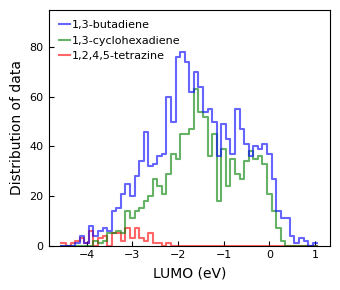

In [10]:
colors = ['b','g','r']
fig, axs = plt.subplots(1,1,figsize=(3.5, 3), tight_layout=True,dpi=100)
bw = 0.1

df = df_pnl.sort_values(by='diene_class',ascending=True)
#df = df_pnl[ df_pnl['diene_class']=='C4' ]
#sns.histplot(df['LUMO'], kde=True, color='k', alpha=1, binwidth=bw, ax=axs, legend=False, fill=False, element="step")
sns.histplot(df, palette=colors, kde=False, alpha=0.6, binwidth=bw, ax=axs, 
             x="LUMO", hue="diene_class", element="step", legend=True, fill=False, ) #multiple="stack", edgecolor=None, )
legend = axs.get_legend()
handles = legend.legendHandles
#legend.remove()
axs.legend(handles, ['1,3-butadiene','1,3-cyclohexadiene','1,2,4,5-tetrazine'], fontsize=8, frameon=False, loc=2, ncol=1, 
               handlelength=1, handletextpad=0.2, columnspacing=1, )#bbox_to_anchor=(0,1.45) )
#titles = ['Training set','Testing set','Validation set']
axs.tick_params(direction='in',labelsize=8)
#axs[n].yaxis.set_major_locator(MaxNLocator(integer=True))
#axs[n].set_yticks(np.arange(0, 8, 2))
#axs[n].set_xlim((-3,5))
#axst[n].set_ylim([0,ytmax[n]])
#axs[n].legend(fontsize=8, frameon=False, loc=2) 
#axs[n].text(0.05, 0.8, titles[n], style='italic', fontsize=9, transform = axs[n].transAxes, color='k')
axs.set_ylim([0,95])
axs.set_xlabel('LUMO (eV)', fontsize=10)
axs.set_ylabel('Distribution of data', fontsize=10)

#plt.subplots_adjust(wspace=0, hspace=0.0)
plt.savefig("DFT_distribution.png", dpi=800)      
plt.show()

In [11]:
feature_col = [c for c in df_pnl.columns if 'rdk_' in c ]#or 'RingCount_' in c ]    

X_features = df_pnl[feature_col]
X_features = clean_std(X_features)
X_features_prop_clean, _ = remove_high_corr_gradually(X_features, cutoff=0.7, )
feature_col = list( X_features_prop_clean.columns )

feature_col = ['LUMO','diene_type','diene_class'] + feature_col
print( feature_col )

df = df_pnl[feature_col]
df

Before clean (2779, 112)
After clean (2779, 101)
Num of keep:  49
Num of drop:  52
---------
['LUMO', 'diene_type', 'diene_class', 'rdk_MaxEStateIndex', 'rdk_MinAbsEStateIndex', 'rdk_FpDensityMorgan1', 'rdk_FpDensityMorgan3', 'rdk_BalabanJ', 'rdk_BertzCT', 'rdk_Chi2n', 'rdk_Chi3v', 'rdk_HallKierAlpha', 'rdk_Kappa3', 'rdk_PEOE_VSA1', 'rdk_PEOE_VSA10', 'rdk_PEOE_VSA11', 'rdk_PEOE_VSA12', 'rdk_PEOE_VSA13', 'rdk_PEOE_VSA14', 'rdk_PEOE_VSA2', 'rdk_PEOE_VSA6', 'rdk_PEOE_VSA7', 'rdk_PEOE_VSA8', 'rdk_PEOE_VSA9', 'rdk_SMR_VSA1', 'rdk_SMR_VSA10', 'rdk_SMR_VSA2', 'rdk_SMR_VSA3', 'rdk_SMR_VSA6', 'rdk_SMR_VSA7', 'rdk_SlogP_VSA10', 'rdk_SlogP_VSA11', 'rdk_SlogP_VSA12', 'rdk_SlogP_VSA2', 'rdk_EState_VSA2', 'rdk_EState_VSA3', 'rdk_EState_VSA4', 'rdk_EState_VSA5', 'rdk_EState_VSA6', 'rdk_EState_VSA7', 'rdk_EState_VSA8', 'rdk_EState_VSA9', 'rdk_VSA_EState10', 'rdk_VSA_EState2', 'rdk_VSA_EState3', 'rdk_VSA_EState4', 'rdk_VSA_EState7', 'rdk_VSA_EState8', 'rdk_NHOHCount', 'rdk_NumHeteroatoms', 'rdk_NumRota

,LUMO,diene_type,diene_class,rdk_MaxEStateIndex,rdk_MinAbsEStateIndex,rdk_FpDensityMorgan1,rdk_FpDensityMorgan3,rdk_BalabanJ,rdk_BertzCT,rdk_Chi2n,...,rdk_VSA_EState10,rdk_VSA_EState2,rdk_VSA_EState3,rdk_VSA_EState4,rdk_VSA_EState7,rdk_VSA_EState8,rdk_NHOHCount,rdk_NumHeteroatoms,rdk_NumRotatableBonds,rdk_MolLogP
N#Cc1nnc(C#N)nn1,-4.55,2_two,N4,8.16,0.14,0.80,1.30,3.08,267.01,1.27,...,0.00,0.00,29.37,0.00,0.00,0.00,0,6,0,-0.99
[H]C(=O)c1nnc(C#N)nn1,-4.30,2_two,N4,9.92,0.13,1.30,2.30,3.04,272.69,1.31,...,0.00,9.92,21.17,0.00,0.40,0.00,0,6,1,-1.05
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N,-4.21,0_three,C4,8.25,0.18,1.10,2.20,4.35,277.44,1.30,...,0.00,0.00,24.35,0.18,3.50,0.00,0,3,1,1.04
[H]O[S@+]([O-])c1nnc(C#N)nn1,-4.19,2_two,N4,10.22,0.24,1.36,2.27,2.94,278.77,1.37,...,-2.30,0.00,20.43,0.00,0.00,0.00,1,8,1,-1.28
[H]C(=O)c1nnc(C([H])=O)nn1,-4.16,2_two,N4,9.91,0.13,0.80,1.30,3.00,216.94,1.35,...,0.00,19.83,12.98,0.00,0.79,0.00,0,6,2,-1.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H])[H])=C(/[H])N(C([H])([H])[H])C([H])([H])[H],0.69,0_two,C4,2.00,2.00,0.70,1.20,3.52,107.22,2.61,...,0.00,4.00,0.00,0.00,8.00,0.00,0,2,3,1.14
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H])[H])=C(/[H])N([H])[H],0.69,0_two,C4,5.06,1.50,1.25,2.25,3.34,92.70,1.69,...,0.00,1.94,0.00,5.06,7.07,0.00,2,2,2,0.53
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])([H])[H])/C([H])=C(\[H])N([H])[H],0.77,0_three,C4,5.13,1.19,1.44,2.33,3.84,122.88,2.09,...,0.00,2.03,0.00,6.32,5.29,2.03,2,2,2,0.92
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H],0.83,0_two,C4,4.93,1.42,0.83,1.33,3.07,53.95,0.77,...,0.00,0.00,0.00,9.85,6.15,0.00,4,2,1,-0.07


In [12]:
Y_prop = df[['LUMO','diene_type','diene_class']]
X_prop = df.drop(['LUMO','diene_type','diene_class'], axis=1)
display(X_prop,Y_prop)

,rdk_MaxEStateIndex,rdk_MinAbsEStateIndex,rdk_FpDensityMorgan1,rdk_FpDensityMorgan3,rdk_BalabanJ,rdk_BertzCT,rdk_Chi2n,rdk_Chi3v,rdk_HallKierAlpha,rdk_Kappa3,...,rdk_VSA_EState10,rdk_VSA_EState2,rdk_VSA_EState3,rdk_VSA_EState4,rdk_VSA_EState7,rdk_VSA_EState8,rdk_NHOHCount,rdk_NumHeteroatoms,rdk_NumRotatableBonds,rdk_MolLogP
N#Cc1nnc(C#N)nn1,8.16,0.14,0.80,1.30,3.08,267.01,1.27,0.68,-2.08,1.01,...,0.00,0.00,29.37,0.00,0.00,0.00,0,6,0,-0.99
[H]C(=O)c1nnc(C#N)nn1,9.92,0.13,1.30,2.30,3.04,272.69,1.31,0.70,-1.90,1.08,...,0.00,9.92,21.17,0.00,0.40,0.00,0,6,1,-1.05
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N,8.25,0.18,1.10,2.20,4.35,277.44,1.30,0.69,-2.05,3.02,...,0.00,0.00,24.35,0.18,3.50,0.00,0,3,1,1.04
[H]O[S@+]([O-])c1nnc(C#N)nn1,10.22,0.24,1.36,2.27,2.94,278.77,1.37,1.19,-1.30,1.81,...,-2.30,0.00,20.43,0.00,0.00,0.00,1,8,1,-1.28
[H]C(=O)c1nnc(C([H])=O)nn1,9.91,0.13,0.80,1.30,3.00,216.94,1.35,0.72,-1.72,1.16,...,0.00,19.83,12.98,0.00,0.79,0.00,0,6,2,-1.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H])[H])=C(/[H])N(C([H])([H])[H])C([H])([H])[H],2.00,2.00,0.70,1.20,3.52,107.22,2.61,0.88,-0.92,7.08,...,0.00,4.00,0.00,0.00,8.00,0.00,0,2,3,1.14
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H])[H])=C(/[H])N([H])[H],5.06,1.50,1.25,2.25,3.34,92.70,1.69,0.61,-0.92,5.08,...,0.00,1.94,0.00,5.06,7.07,0.00,2,2,2,0.53
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])([H])[H])/C([H])=C(\[H])N([H])[H],5.13,1.19,1.44,2.33,3.84,122.88,2.09,1.15,-0.92,3.64,...,0.00,2.03,0.00,6.32,5.29,2.03,2,2,2,0.92
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H],4.93,1.42,0.83,1.33,3.07,53.95,0.77,0.33,-0.92,3.08,...,0.00,0.00,0.00,9.85,6.15,0.00,4,2,1,-0.07


,LUMO,diene_type,diene_class
N#Cc1nnc(C#N)nn1,-4.55,2_two,N4
[H]C(=O)c1nnc(C#N)nn1,-4.30,2_two,N4
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N,-4.21,0_three,C4
[H]O[S@+]([O-])c1nnc(C#N)nn1,-4.19,2_two,N4
[H]C(=O)c1nnc(C([H])=O)nn1,-4.16,2_two,N4
...,...,...,...
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H])[H])=C(/[H])N(C([H])([H])[H])C([H])([H])[H],0.69,0_two,C4
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H])[H])=C(/[H])N([H])[H],0.69,0_two,C4
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])([H])[H])/C([H])=C(\[H])N([H])[H],0.77,0_three,C4
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H],0.83,0_two,C4


Total Var  0.8040318830427311  from  12
Exp Var:  [0.1802075  0.10678137 0.09811223 0.08412255 0.06630471 0.06179729
 0.04933261 0.0414712  0.03563153 0.03030089 0.02662146 0.02334853]


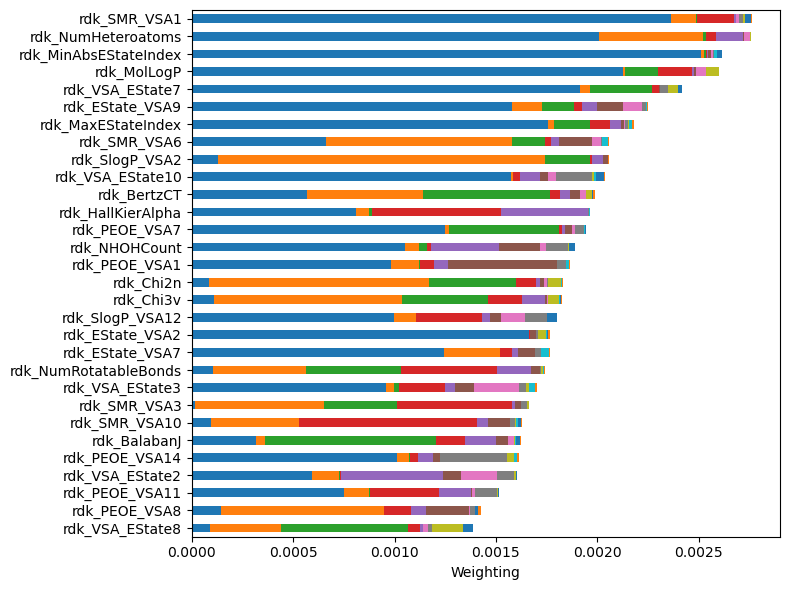

In [18]:
n_pca =0.8
df2_pca, df2_pca_coef, exp_var = perform_pca_n(X_prop, n_pca, if_plot=True, top_features=0.5)

'In plot'

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,length
rdk_SMR_VSA1,-0.27,0.11,-0.01,-0.16,-0.04,0.02,0.07,0.12,-0.07,-0.02,-0.21,0.09,0.00
rdk_NumHeteroatoms,-0.25,0.21,0.04,-0.08,0.17,0.03,-0.11,0.00,0.03,-0.06,0.00,-0.02,0.00
rdk_MinAbsEStateIndex,0.28,0.04,0.03,0.03,0.03,-0.06,0.06,0.06,0.03,-0.11,-0.18,-0.04,0.00
rdk_MolLogP,0.26,0.03,-0.13,-0.15,-0.05,0.06,-0.14,0.01,-0.22,-0.01,-0.04,-0.03,0.00
rdk_VSA_EState7,0.24,0.07,-0.18,-0.07,-0.00,0.03,0.01,0.15,0.20,-0.02,-0.16,0.01,0.00
rdk_EState_VSA9,-0.22,-0.11,-0.13,0.08,0.13,-0.18,-0.20,0.11,-0.03,-0.06,0.04,-0.06,0.00
rdk_MaxEStateIndex,-0.23,0.05,-0.14,-0.12,-0.11,0.06,0.03,-0.10,0.05,-0.13,0.06,0.13,0.00
rdk_SMR_VSA6,0.14,0.28,0.13,0.06,-0.10,-0.21,-0.13,-0.06,-0.02,0.17,0.06,0.07,0.00
rdk_SlogP_VSA2,-0.06,0.38,0.15,0.04,-0.11,-0.08,-0.01,0.01,-0.04,0.03,-0.01,0.04,0.00
rdk_VSA_EState10,0.22,-0.03,-0.01,0.07,-0.15,0.10,-0.13,0.32,0.08,0.10,0.25,0.04,0.00


0 rdk_SMR_VSA1
1 rdk_NumHeteroatoms
2 rdk_MinAbsEStateIndex
3 rdk_MolLogP
4 rdk_VSA_EState7
5 rdk_EState_VSA9
6 rdk_MaxEStateIndex
7 rdk_SMR_VSA6
8 rdk_SlogP_VSA2
9 rdk_VSA_EState10
10 rdk_BertzCT
11 rdk_HallKierAlpha


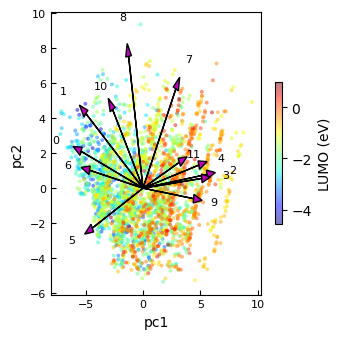

In [19]:
colors = Y_prop['LUMO']
plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', 
            feature_arrow=True, size=8, explained_var=exp_var, num_feature=12,)
           #save_to_file='Figure_PCA_PNL_rdk.png' )# yrange=[-5,10] )

['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12']


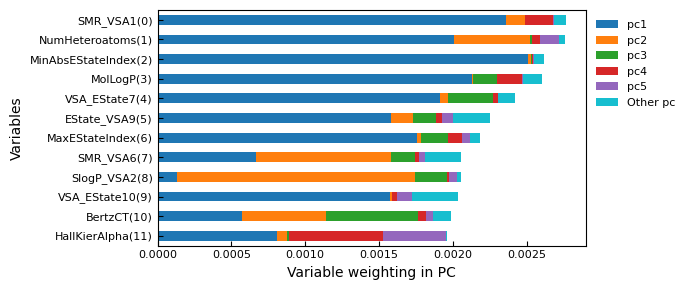

In [20]:
feature_weight( df2_pca_coef, exp_var, num_variable=12, if_var_considered=True, header='rdk_',)# save_to_file='Figure_PCA_PNL_rdk_TopFeatures.png')


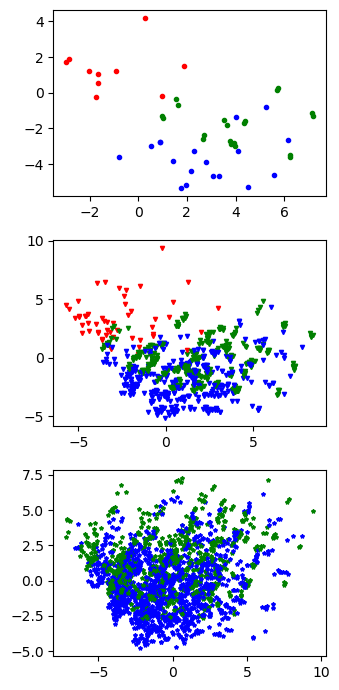

In [21]:
colors, shapes = [],[]
for d in Y_prop['diene_type']:
    if '0' in d:
        colors.append('b')
    elif '1' in d:
        colors.append('g')
    else:
        colors.append('r')
        
    if 'one' in d:
        shapes.append('o')
    elif 'two' in d:
        shapes.append('v')
    else:
        shapes.append('*')

        
pc_x = df2_pca['pc1']
pc_y = df2_pca['pc2']
energy = Y_prop['LUMO']

fig, axs = plt.subplots(3,1,figsize=(3.5, 7), tight_layout=True,dpi=100)
for x,y,e,c,s in zip(pc_x,pc_y,energy, colors, shapes):
    if s=='o':
        i = 0
    elif s=='v':
        i = 1
    else:
        i = 2
    axs[i].plot(x,y, color=c, lw=2, ls='', marker=s, ms=3) 

#legend = axs.get_legend()
#handles = legend.legendHandles
#legend.remove()
#axs.legend(handles, ['1,3-butadiene','1,3-cyclohexadiene','1,2,4,5-tetrazine'], fontsize=8, frameon=False, loc=2, ncol=1, 
#               handlelength=1, handletextpad=0.2, columnspacing=1, )#bbox_to_anchor=(0,1.45) )
#titles = ['Training set','Testing set','Validation set']
#axs.tick_params(direction='in',labelsize=8)
#axs[n].yaxis.set_major_locator(MaxNLocator(integer=True))
#axs[n].set_yticks(np.arange(0, 8, 2))
#axs[n].set_xlim((-3,5))
#axst[n].set_ylim([0,ytmax[n]])
#axs[n].legend(fontsize=8, frameon=False, loc=2) 
#axs[n].text(0.05, 0.8, titles[n], style='italic', fontsize=9, transform = axs[n].transAxes, color='k')
#axs.set_ylim([0,95])
#axs.set_xlabel('LUMO (eV)', fontsize=10)
#axs.set_ylabel('Distribution of data', fontsize=10)

#plt.subplots_adjust(wspace=0, hspace=0.0)
#plt.savefig("spliting_detail.png", dpi=800)      
plt.show()

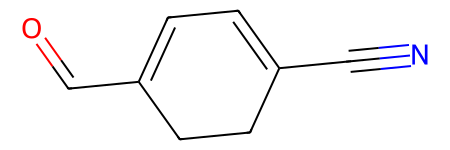

{0: ['*C=O'], 3: ['*C#N']}

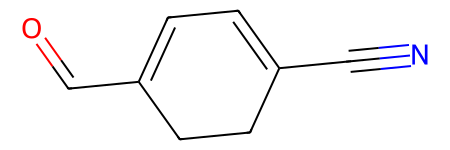

{1: ['*C#N'], 4: ['*C=O']}

In [37]:
s='[H]C(=O)C1=C([H])C([H])=C(C#N)C([H])([H])C1([H])[H]'
loc = locate_func( s, pattern='C=CC=C', pattern_ngb=[1,2,2,1] )
display( Chem.MolFromSmiles(s), loc )
loc = locate_func( s, pattern='C1C=CC=CC1', pattern_ngb=[2,2,2,2,2,2] )
display( Chem.MolFromSmiles(s), loc )

In [99]:
func1 = ['*N(C)C','*N','*O','*OC',  '*SC','*C']   # EDG
func2 = ['*C=O','*C(=O)O',   '*C#N','*S(=O)O','*[S+]([O-])O' ]  # EWG
#img = Draw.MolsToGridImage( [Chem.MolFromSmiles(p) for p in func1], molsPerRow=15, subImgSize=(400, 300), returnPNG=False )# ,legends=[func[n] for n in range(len(func))] )  
#display(img)

fps = []
for s,c,t in zip( Y_prop.index, Y_prop['diene_class'], Y_prop['diene_type'] ):
    if c=='C4':
        pat = 'C=CC=C'
        pat_ngb = [1,2,2,1] 
    elif c=='C6':
        pat = 'C1C=CC=CC1'
        pat_ngb = [2,2,2,2,2,2]
    else:
        pat = 'C1=NN=CN=N1'
        pat_ngb = [2,2,2,2,2,2]        
    loc = locate_func( s, pattern=pat, pattern_ngb=pat_ngb )
    fp = [0,0,0,0,0,0]  # C4 only has 0-3, C6 only has 1-4; N4 only has 0 and 3.
    #print( loc, fp )
    
    for k,v in loc.items():
        b = [ 1 if group.replace('@','') in func1 else -1 if group.replace('@','') in func2 else 0 for group in v ]
        #print( k, v, b )
        b = np.sum(b)
        if b == -1:
            fp[k] = 1 ## 1 EWG
        elif b == -2:
            fp[k] = 2 ## 2 EWG
        elif b == 1:
            fp[k] = 3 ## 1 EDG
        elif b == 2:
            fp[k] = 4 ## 2 EDG
        elif b == 0:
            fp[k] = 5 ## 1 EWG + 1 EDG
    fp = ''.join([str(f) for f in fp])
    fps.append( fp )
fps = np.array(fps)
fps

array(['100100', '100100', '101100', ..., '400300', '300300', '400300'],
      dtype='<U6')

,index,ID,EWG,EDG,Combined
0,9,430000,0,3,03
1,26,333000,0,3,03
2,31,003330,0,3,03
3,41,403000,0,3,03
4,53,330300,0,3,03
...,...,...,...,...,...
137,65,210000,3,0,30
138,66,001110,3,0,30
139,93,201000,3,0,30
140,95,010200,3,0,30


0      03
13     02
24     01
28     12
61     11
81     10
86     21
119    20
130    30
Name: Combined, dtype: object

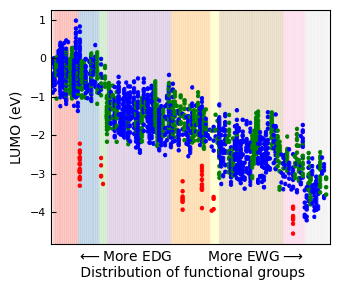

In [151]:
colors, shapes = [],[]
for d in Y_prop['diene_type']:
    if '0' in d:
        colors.append('b')
    elif '1' in d:
        colors.append('g')
    else:
        colors.append('r')
    if 'one' in d:
        shapes.append('o')
    elif 'two' in d:
        shapes.append('v')
    else:
        shapes.append('^')
colors = np.array( colors )
shapes = np.array( shapes )

fig, axs = plt.subplots(1,1,figsize=(3.5, 3), tight_layout=True,dpi=100)

all_patterns = list(set(fps))
n_ewg, n_edg, n_both = [],[],[]
for p in all_patterns:
    w=p.count('1')+p.count('2')*2+p.count('5') 
    d=p.count('3')+p.count('4')*2+p.count('5')
    n_ewg.append( w)
    n_edg.append( d)
    n_both.append( str(w)+str(d) )
all_patterns = pd.DataFrame( [all_patterns,n_ewg,n_edg,n_both] ).T
all_patterns.columns = ['ID','EWG','EDG','Combined']
all_patterns = all_patterns.sort_values(by=['EWG', 'EDG'], ascending=[True, False] ).reset_index()
display( all_patterns )

d_combined = all_patterns['Combined'].drop_duplicates()
cmap = plt.get_cmap('Pastel1')
colors_shade = cmap(np.linspace(0, 1, len(d_combined)))
colors_shade = { d:c for d,c in zip(d_combined, colors_shade) }
display( d_combined )

for n, (p, c_shade) in enumerate( zip(all_patterns['ID'],all_patterns['Combined']) ):       
    axs.axvspan( n,n+1, color=colors_shade[c_shade], alpha=0.5)
    mask = fps==p
    y = Y_prop[mask]['LUMO']
    c = colors[mask]
    s = shapes[mask]
    axs.scatter( len(y)*[n], y, c=c, marker='o', s=5 ) 

axs.tick_params(direction='in',labelsize=8)
axs.set_xlim((-1,len(all_patterns)+1))
axs.set_xticklabels([])
axs.set_xticks([])
axs.set_ylabel('LUMO (eV)', fontsize=10)
axs.set_xlabel(r'$\longleftarrow$More EDG        More EWG$\longrightarrow$'+"\n Distribution of functional groups", fontsize=10)
#plt.subplots_adjust(wspace=0, hspace=0.0)
plt.savefig("LUMO_distribution.png", dpi=800)      
plt.show()

# ML development

In [158]:
feature_col = [c for c in df_pnl.columns if 'rdk_' in c ]#or 'RingCount_' in c ]    

X_features = df_pnl[feature_col]
X_features = clean_std(X_features)
X_features_prop_clean, _= remove_high_corr_gradually(X_features, cutoff=0.7 )
feature_col = list( X_features_prop_clean.columns )

feature_col = ['LUMO','diene_type','diene_class'] + feature_col
print( feature_col )
df_pnl = df_pnl[feature_col]

df_pnl_c4 = df_pnl[ df_pnl['diene_class'] =='C4' ]
df_pnl_c6 = df_pnl[ df_pnl['diene_class'] =='C6' ]
df_pnl_n4 = df_pnl[ df_pnl['diene_class'] =='N4' ]

data_prop = []
for df in [df_pnl_c4, df_pnl_c6, df_pnl_n4]:
    Y_prop = df[['LUMO','diene_type','diene_class']]
    X_prop = df.drop(['LUMO','diene_type','diene_class'],axis=1)
    data_prop.append( [X_prop,Y_prop] )


Before clean (2779, 112)
After clean (2779, 101)
Num of keep:  49
Num of drop:  52
---------
['LUMO', 'diene_type', 'diene_class', 'rdk_MaxEStateIndex', 'rdk_MinAbsEStateIndex', 'rdk_FpDensityMorgan1', 'rdk_FpDensityMorgan3', 'rdk_BalabanJ', 'rdk_BertzCT', 'rdk_Chi2n', 'rdk_Chi3v', 'rdk_HallKierAlpha', 'rdk_Kappa3', 'rdk_PEOE_VSA1', 'rdk_PEOE_VSA10', 'rdk_PEOE_VSA11', 'rdk_PEOE_VSA12', 'rdk_PEOE_VSA13', 'rdk_PEOE_VSA14', 'rdk_PEOE_VSA2', 'rdk_PEOE_VSA6', 'rdk_PEOE_VSA7', 'rdk_PEOE_VSA8', 'rdk_PEOE_VSA9', 'rdk_SMR_VSA1', 'rdk_SMR_VSA10', 'rdk_SMR_VSA2', 'rdk_SMR_VSA3', 'rdk_SMR_VSA6', 'rdk_SMR_VSA7', 'rdk_SlogP_VSA10', 'rdk_SlogP_VSA11', 'rdk_SlogP_VSA12', 'rdk_SlogP_VSA2', 'rdk_EState_VSA2', 'rdk_EState_VSA3', 'rdk_EState_VSA4', 'rdk_EState_VSA5', 'rdk_EState_VSA6', 'rdk_EState_VSA7', 'rdk_EState_VSA8', 'rdk_EState_VSA9', 'rdk_VSA_EState10', 'rdk_VSA_EState2', 'rdk_VSA_EState3', 'rdk_VSA_EState4', 'rdk_VSA_EState7', 'rdk_VSA_EState8', 'rdk_NHOHCount', 'rdk_NumHeteroatoms', 'rdk_NumRota

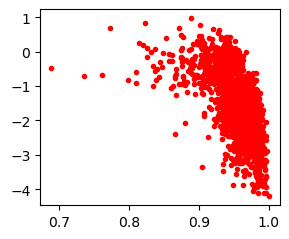

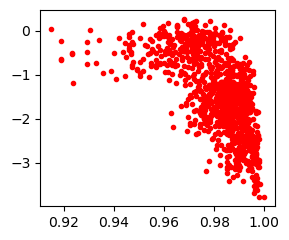

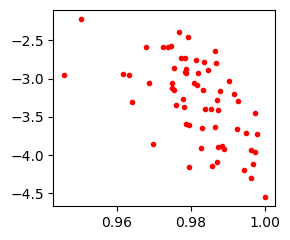

In [159]:
from numpy.linalg import norm

for data in data_prop:
    X_prop = data[0]
    Y_prop = data[1]['LUMO']

    ref = X_prop.iloc[0].values
    sel = X_prop.values

    cosine = np.dot(sel,ref)/(norm(sel,axis=1)*norm(ref))
    X_prop['COS'] = cosine

    fig, axs = plt.subplots(1,1,figsize=(3,2.5),tight_layout=True,dpi=100)
    axs.plot(X_prop['COS'], Y_prop, color='r', lw=2, ls='', marker='o', ms=3) 
    plt.show()

Train, Test, Val sizes are:  (987, 50) (330, 50) (329, 50)
Train, Test, Val sizes are:  (642, 50) (214, 50) (214, 50)
Train, Test, Val sizes are:  (37, 50) (13, 50) (13, 50)


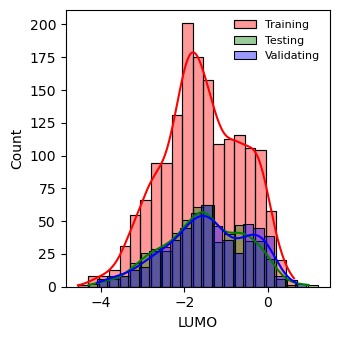

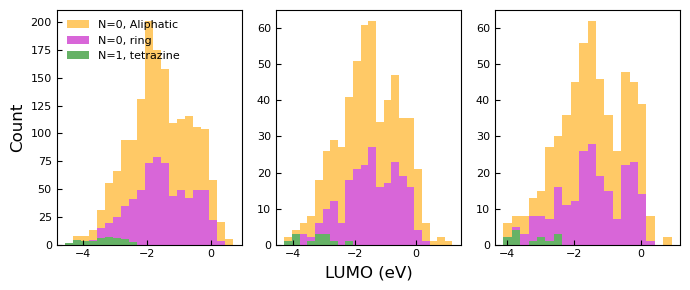

In [160]:
global_random_seed_number = 421

# The order is: df_pnl_c4, df_pnl_c6, df_pnl_n4
use_index = [0,1,2] # loop which subsets
all_prop = []  
for i in use_index:
    X_prop = data_prop[i][0]
    Y_prop = data_prop[i][1]
    x_train, x_test, x_val, y_train, y_test, y_val = split_data(X_prop, Y_prop, rand_state=global_random_seed_number)
    data = {'x_train':x_train, 'x_test':x_test, 'x_val':x_val, 'y_train':y_train, 'y_test':y_test, 'y_val':y_val}
    all_prop.append( data )
    
df_prop = {}  ## All together 
for k in all_prop[0].keys():  ## loop x_train, x_test,...
    df = pd.concat( [ data[k] for data in all_prop ] ,axis=0 )
    df_prop[k] = df
    
df_prop = standard_dataset(df_prop)

fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True,dpi=100)
#df_prop['y_val'].plot(kind='bar', stacked=False, x='type', y='LUMO', ax=axs)
sns.histplot(df_prop['y_train']['LUMO'],  kde=True, color='r', alpha=0.4, label='Training', binwidth=0.25, ax=axs)
sns.histplot(df_prop['y_test']['LUMO'],  kde=True, color='g', alpha=0.4, label='Testing', binwidth=0.25, ax=axs)
sns.histplot(df_prop['y_val']['LUMO'],   kde=True, color='b', alpha=0.4, label='Validating', binwidth=0.25, ax=axs)
axs.legend(fontsize=8, frameon=False)
plt.show()

colors = ['orange','m','g','b','c','r']
fig, axs = plt.subplots(1,3,figsize=(7,3),tight_layout=True,dpi=100)
sns.histplot(df_prop['y_train'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=0.25, ax=axs[0], x="LUMO", hue="diene_class", element="step", legend=True, multiple="stack")
sns.histplot(df_prop['y_test'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=0.25, ax=axs[1], x="LUMO", hue="diene_class", element="step", legend=False, multiple="stack")
sns.histplot(df_prop['y_val'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=0.25, ax=axs[2], x="LUMO", hue="diene_class", element="step", legend=False, multiple="stack")
legend = axs[0].get_legend()
handles = legend.legendHandles
#legend.remove()
axs[0].legend(handles, ['N=0, Aliphatic','N=0, ring','N=1, tetrazine'], fontsize=8, frameon=False, loc=2)
for n in range(3):
    axs[n].set_xlabel('', fontsize=10)
    axs[n].set_ylabel('')    
    #axs[n].set_xticks( [] )
    #axs[n].set_xlim((-4.9,2.5))
    axs[n].set_ylim(bottom=0)
    axs[n].tick_params(direction='in',labelsize=8)
    #axs[n].legend_.remove()
axs[1].set_xlabel('LUMO (eV)', fontsize=12)
axs[0].set_ylabel('Count', fontsize=12)
plt.show()

In [55]:
from sklearn.utils import all_estimators
from sklearn.base import RegressorMixin

import xgboost
import lightgbm

removed_regressors = [
    "TheilSenRegressor",
    "ARDRegression", 
    "CCA", 
    "IsotonicRegression", 
    "StackingRegressor",
    "MultiOutputRegressor", 
    "MultiTaskElasticNet", 
    "MultiTaskElasticNetCV", 
    "MultiTaskLasso", 
    "MultiTaskLassoCV", 
    "PLSCanonical", 
    "PLSRegression", 
    "RadiusNeighborsRegressor", 
    "RegressorChain", 
    "VotingRegressor",
    
    "PoissonRegressor",
    "QuantileRegressor",
]

chosen_regressors = [
    'SVR',
    'BaggingRegressor'
]

my_REGRESSORS = [
    est
    for est in all_estimators()
    #if (issubclass(est[1], RegressorMixin) and (est[0] in chosen_regressors))
    if (issubclass(est[1], RegressorMixin) and (est[0] not in removed_regressors))  
]

my_REGRESSORS.append(("XGBRegressor", xgboost.XGBRegressor))
my_REGRESSORS.append(("LGBMRegressor", lightgbm.LGBMRegressor))

for i,r in enumerate(my_REGRESSORS):
    print(i, r[0])
    
def screen_ML_performance(df_prop, regressors=my_REGRESSORS):
    x_train = df_prop['x_train']
    x_test = df_prop['x_test']
    x_val = df_prop['x_val'] 
    y_train = df_prop['y_train']['LUMO']
    y_test = df_prop['y_test']['LUMO']
    y_val =df_prop['y_val']['LUMO']
    
    colors = ['orange','m','g','b','c','r']
    fig, axs = plt.subplots(3,1,figsize=(3.5,3.) )#,tight_layout=True,dpi=100)
    axst = [a.twinx() for a in axs]
    bw = 0.2
    sns.histplot(y_train, kde=False, color='r', alpha=1, binwidth=bw, ax=axs[0], legend=False, fill=True, element="step", label='Training')
    sns.histplot(y_test,  kde=False, color='g', alpha=1, binwidth=bw, ax=axs[1], legend=False, fill=True, element="step", label='Testing')
    sns.histplot(y_val,   kde=False, color='b', alpha=1, binwidth=bw, ax=axs[2], legend=False, fill=True, element="step", label='Validation')
    sns.kdeplot(y_train, color='k', alpha=1, ax=axst[0], legend=False, fill=False)
    sns.kdeplot(y_test,  color='k', alpha=1, ax=axst[1], legend=False, fill=False)
    sns.kdeplot(y_val,   color='k', alpha=1, ax=axst[2], legend=False, fill=False)

    tit = ['Training','Testing','Validating']
    #ymax= [8.5,8.5,8.5]
    #ytmax= [0.3, 0.3, 0.3]
    for n in range(3):
        axs[n].tick_params(direction='in',labelsize=8)
        axs[n].set_xlabel('', fontsize=10)
        axs[n].set_ylabel('') 
        #axs[n].yaxis.set_major_locator(MaxNLocator(integer=True))
        #axs[n].set_yticks(np.arange(0, 8, 2))
        axst[n].set_ylabel('') 
        axst[n].set_xlabel('') 
        axst[n].set_yticks( [] )
        axst[n].set_yticklabels([])
        #axs[n].set_xlim((-3,5))
        #axs[n].set_ylim([0,ymax[n]])
        #axst[n].set_ylim([0,ytmax[n]])
        axs[n].legend(fontsize=8, frameon=False, loc=2) 
    axs[0].set_xticklabels([])
    axs[1].set_xticklabels([])
    axs[2].set_xlabel('LUMO (eV)', fontsize=10)
    axs[1].set_ylabel('Number of data points', fontsize=10)

    plt.subplots_adjust(wspace=0, hspace=0.0)
    #plt.savefig("spliting_detail.png", dpi=800)      
    plt.show()    
    
    scaler = df_prop['scaler']
    
    model_ml, lazy_ml = do_lazy_regression(df_prop, ylabel='LUMO', rg=regressors)

    rmse = model_ml[ model_ml['RMSE']<3 ].sort_values(by='RMSE',ascending=False)
    
    fig, axs = plt.subplots(1,1,figsize=(3.5,2.5),tight_layout=True,dpi=100)
    rmse.plot(kind='bar', y=['RMSE'], color=['blueviolet'], ax=axs, legend=False, fontsize=8)  ##figsize=(12,3)
    
    #axs.tick_params(direction='in',labelsize=8)
    axs.set_ylabel('Model RMSE', fontsize=10)
    axs.set_xlabel('ML models', fontsize=10)
    axs.set_xticklabels( [n for n in range(len(rmse))], rotation=0, ha='center')
    
    axt = axs.twinx()
    #axt.tick_params(direction='in',labelsize=8)
    axt.set_xticks( [] )
    axt.set_ylabel('Model R$^2$', fontsize=10)
    rmse.plot(kind='line', y=['R-Squared'], color=['limegreen'], ax=axt, legend=False, fontsize=8, xlabel=None)
    axt.set_ylim((0,1))
    
    rr = np.round( [rmse['R-Squared'].tail(1), rmse['RMSE'].tail(1)], 2)
    rr = f'Best performance:\nRMSE={rr[1][0]}\nR2 score={rr[0][0]}'
    #axs.text(0.4,0.6, rr, style='italic', fontsize=12, transform = axs.transAxes, color='k')
    
    #axs.legend(fontsize=8, frameon=False)
    #axt.legend(fontsize=8, frameon=False)
    handles = axs.get_legend_handles_labels()[0]+axt.get_legend_handles_labels()[0]
    labels = axs.get_legend_handles_labels()[1]+['R$^2$']  ##axt.get_legend_handles_labels()[1]
    plt.legend( handles,labels, loc='center right', fontsize=10, frameon=False,  bbox_to_anchor=(0.99, 0.7))
    
    rect = axs.patches[-1]
    rect.set_fc( 'r' )
    
    plt.savefig("ml_modeling_selection.png", dpi=800)  
    plt.show()
    display(rmse)
    
    rmse.to_csv('ml_modeling_selection.csv')

0 AdaBoostRegressor
1 BaggingRegressor
2 BayesianRidge
3 DecisionTreeRegressor
4 DummyRegressor
5 ElasticNet
6 ElasticNetCV
7 ExtraTreeRegressor
8 ExtraTreesRegressor
9 GammaRegressor
10 GaussianProcessRegressor
11 GradientBoostingRegressor
12 HistGradientBoostingRegressor
13 HuberRegressor
14 KNeighborsRegressor
15 KernelRidge
16 Lars
17 LarsCV
18 Lasso
19 LassoCV
20 LassoLars
21 LassoLarsCV
22 LassoLarsIC
23 LinearRegression
24 LinearSVR
25 MLPRegressor
26 NuSVR
27 OrthogonalMatchingPursuit
28 OrthogonalMatchingPursuitCV
29 PassiveAggressiveRegressor
30 RANSACRegressor
31 RandomForestRegressor
32 Ridge
33 RidgeCV
34 SGDRegressor
35 SVR
36 TransformedTargetRegressor
37 TweedieRegressor
38 XGBRegressor
39 LGBMRegressor


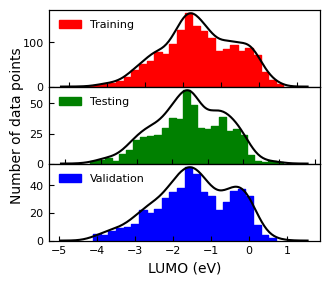

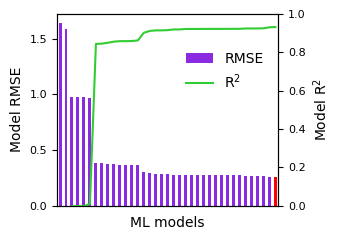

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GaussianProcessRegressor,-2.12,-1.84,1.64,0.37
KernelRidge,-1.94,-1.67,1.59,0.11
LassoLars,-0.10,-0.00,0.97,0.02
DummyRegressor,-0.10,-0.00,0.97,0.02
Lasso,-0.10,-0.00,0.97,0.01
ElasticNet,-0.09,0.01,0.97,0.02
TweedieRegressor,0.83,0.84,0.38,0.03
ExtraTreeRegressor,0.83,0.85,0.38,0.06
DecisionTreeRegressor,0.84,0.85,0.38,0.16


In [56]:
%%capture --no-display

#random_seed = 50 # 126843 for not-reordered, no S
screen_ML_performance(df_prop)

Train, Test, Val sizes are:  (987, 50) (330, 50) (329, 50)
Train, Test, Val sizes are:  (642, 50) (214, 50) (214, 50)
Train, Test, Val sizes are:  (37, 50) (13, 50) (13, 50)


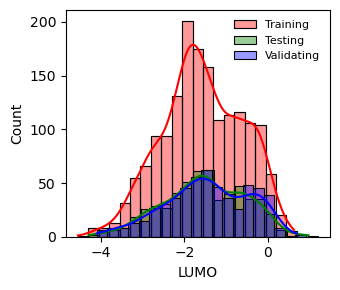

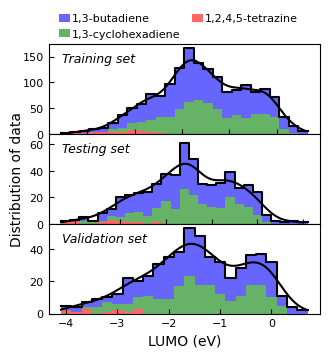

In [161]:
# Finalize a model
# The order is: df_pnl_c4, df_pnl_c6, df_pnl_n4
use_index = [0,1,2] # loop which subsets

all_prop = []  
for i in use_index:
    X_prop = data_prop[i][0]
    Y_prop = data_prop[i][1]
    x_train, x_test, x_val, y_train, y_test, y_val = split_data(X_prop, Y_prop, rand_state=global_random_seed_number)
    data = {'x_train':x_train, 'x_test':x_test, 'x_val':x_val, 'y_train':y_train, 'y_test':y_test, 'y_val':y_val}
    all_prop.append( data )
    
df_prop = {}  ## All together 
for k in all_prop[0].keys():  ## loop x_train,xtest,...
    df = pd.concat( [ data[k] for data in all_prop ] ,axis=0 )
    df_prop[k] = df

df_prop = standard_dataset(df_prop)

fig, axs = plt.subplots(1,1,figsize=(3.5,3),tight_layout=True,dpi=100)
sns.histplot(df_prop['y_train']['LUMO'], kde=True, color='r', alpha=0.4, label='Training', binwidth=0.25, ax=axs)
sns.histplot(df_prop['y_test']['LUMO'],  kde=True, color='g', alpha=0.4, label='Testing', binwidth=0.25, ax=axs)
sns.histplot(df_prop['y_val']['LUMO'],   kde=True, color='b', alpha=0.4, label='Validating', binwidth=0.25, ax=axs)
axs.legend(fontsize=8, frameon=False)
#plt.savefig("spliting.png", dpi=800)      
plt.show()

colors = ['b','g','r']
fig, axs = plt.subplots(3,1,figsize=(3.5,3.5),)#tight_layout=True,dpi=100)
bw = 0.2
sns.histplot(df_prop['y_train']['LUMO'], kde=True, color='k', alpha=1, binwidth=bw, ax=axs[0], legend=False, fill=False, element="step")
sns.histplot(df_prop['y_test']['LUMO'],  kde=True, color='k', alpha=1, binwidth=bw, ax=axs[1], legend=False, fill=False, element="step")
sns.histplot(df_prop['y_val']['LUMO'],   kde=True, color='k', alpha=1, binwidth=bw, ax=axs[2], legend=False, fill=False, element="step")

sns.histplot(df_prop['y_train'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=bw, ax=axs[0], x="LUMO", hue="diene_class", element="step", legend=True, multiple="stack")
sns.histplot(df_prop['y_test'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=bw, ax=axs[1], x="LUMO", hue="diene_class", element="step", legend=False, multiple="stack")
sns.histplot(df_prop['y_val'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=bw, ax=axs[2], x="LUMO", hue="diene_class", element="step", legend=False, multiple="stack")
legend = axs[0].get_legend()
handles = legend.legendHandles
#legend.remove()
axs[0].legend(handles, ['1,3-butadiene','1,3-cyclohexadiene','1,2,4,5-tetrazine'], fontsize=8, frameon=False, loc=2, ncol=2, 
               handlelength=1, handletextpad=0.2, columnspacing=1, bbox_to_anchor=(0,1.45) )
titles = ['Training set','Testing set','Validation set']

for n in range(3):
    axs[n].tick_params(direction='in',labelsize=8)
    axs[n].set_xlabel('', fontsize=10)
    axs[n].set_ylabel('') 
    #axs[n].yaxis.set_major_locator(MaxNLocator(integer=True))
    #axs[n].set_yticks(np.arange(0, 8, 2))
    #axs[n].set_xlim((-3,5))
    #axst[n].set_ylim([0,ytmax[n]])
    #axs[n].legend(fontsize=8, frameon=False, loc=2) 
    axs[n].text(0.05, 0.8, titles[n], style='italic', fontsize=9, transform = axs[n].transAxes, color='k')
axs[1].set_ylim([0,68])
axs[0].set_xticklabels([])
axs[1].set_xticklabels([])
axs[2].set_xlabel('LUMO (eV)', fontsize=10)
axs[1].set_ylabel('Distribution of data', fontsize=10)

plt.subplots_adjust(wspace=0, hspace=0.0)
    
plt.savefig("spliting_detail.png", dpi=800)      
plt.show()

In [46]:
%%capture --no-display
import lightgbm

# Hyper tuning
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'num_leaves': np.arange(20, 50),
    'max_depth': np.arange(4, 25),
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
random_search = RandomizedSearchCV(estimator=lightgbm.LGBMRegressor(), param_distributions=param_dist, n_iter=200, cv=5, scoring='neg_mean_absolute_error', verbose=0)
#random_search.fit( df_prop['x_train'], df_prop['y_train']['LUMO'] )
df_x = pd.concat( [df_prop['x_train'],df_prop['x_test'],df_prop['x_val']], axis=0 )
df_y = pd.concat( [df_prop['y_train'],df_prop['y_test'],df_prop['y_val']], axis=0 )
random_search.fit( df_x, df_y['LUMO'] )

display("Best hyperparameters:")
parameter = random_search.best_params_
for k,v in parameter.items():
    display(k,v)
display("Best accuracy:", random_search.best_score_, )

model_all = random_search.best_estimator_
test_accuracy = model_all.score( df_prop['x_test'], df_prop['y_test']['LUMO'] )
display("Test accuracy:", test_accuracy)
val_accuracy = model_all.score( df_prop['x_val'], df_prop['y_val']['LUMO'] )
display("Validation accuracy:", val_accuracy)

'Best hyperparameters:'

'subsample'

1.0

'num_leaves'

41

'n_estimators'

250

'max_depth'

6

'learning_rate'

0.1

'colsample_bytree'

1.0

'Best accuracy:'

-0.1963153724919082

'Test accuracy:'

0.9886425637429065

'Validation accuracy:'

0.9896791002030857

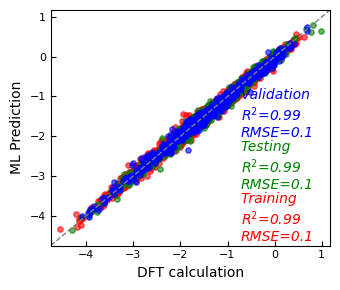

In [99]:
y_train_predict = model_all.predict(df_prop['x_train'].values)
y_test_predict = model_all.predict(df_prop['x_test'].values)
y_val_predict = model_all.predict(df_prop['x_val'].values)

train_score = model_all.score(df_prop['x_train'], df_prop['y_train']['LUMO'])
test_score = model_all.score(df_prop['x_test'], df_prop['y_test']['LUMO'])
val_score = model_all.score(df_prop['x_val'], df_prop['y_val']['LUMO'])

train_rmse = metrics.mean_squared_error(  df_prop['y_train']['LUMO'], y_train_predict, squared=False)
test_rmse = metrics.mean_squared_error(  df_prop['y_test']['LUMO'], y_test_predict, squared=False)
val_rmse = metrics.mean_squared_error(  df_prop['y_val']['LUMO'], y_val_predict, squared=False)

r2 = [train_score, test_score, val_score]
rmse = [train_rmse, test_rmse, val_rmse]

dx = [df_prop['y_train']['LUMO'].values, df_prop['y_test']['LUMO'].values, df_prop['y_val']['LUMO'].values]
dy = [y_train_predict, y_test_predict, y_val_predict]
colors = ['r','g','b']

fig, axs = plt.subplots(1,1,figsize=(3.5,3),tight_layout=True,dpi=100)

axlim = [100000,-1000000]
for n in [0,1,2]:
    x=dx[n]
    y=dy[n]
    c=colors[n]
    axs.scatter(x,y,  marker='o', c=c, s=15, alpha=0.6)  
    if np.amin([x,y])<axlim[0]:
        axlim[0] = np.amin([x,y])-0.2
    if np.amax([x,y])>axlim[1]:
        axlim[1] = np.amax([x,y])+0.2
axs.plot(axlim,axlim, '--', color='gray', lw=1)

axs.set_xlim(axlim)
axs.set_ylim(axlim)
#a, b = np.polyfit(our_exp_logs,[-2.68,-2.915,-3.075,-3.598], 1)
#axs.plot(df_plot['logS'], a*np.array(df_plot['logS'])+b, color='r', linestyle='--') 
axs.set_xlabel('DFT calculation',fontsize=10) ## input X name
axs.set_ylabel('ML Prediction',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')

label = ['Training','Testing','Validation']
for n in [0,1,2]:
    line = f'{label[n]} \nR$^2$={round(r2[n],2)} \nRMSE={round(rmse[n],2)}'
    axs.text(0.68,0.02+0.22*n, line, style='italic', fontsize=10, transform = axs.transAxes, color=colors[n])

#plt.savefig('training.png', dpi=800)
plt.show()


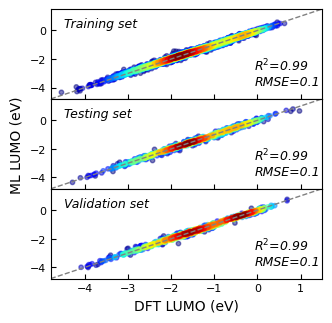

In [100]:
fig, axs = plt.subplots(3,1,figsize=(3.5,3.5), layout='constrained' )#tight_layout=True,dpi=100)

axlim = [-4.8, 1.5]
for n in [0,1,2]:
    x=dx[n]
    y=dy[n]
    #c=colors[n]
    #axs[n].scatter(x,y,  marker='o', c=c, s=15, alpha=0.6)  
    x,y,c = color_density(x,y)
    im = axs[n].scatter(x, y, marker='o', c=c, cmap='jet', label='', alpha=0.5, s=10) 
    axs[n].plot(axlim,axlim, '--', color='gray', lw=1)
    axs[n].set_xlim(axlim)
    axs[n].set_ylim(axlim)
    axs[n].tick_params(direction='in',labelsize=8)
    axs[n].set_xlabel('', fontsize=10)
    axs[n].set_ylabel('') 
    #axs[n].set_xticks(np.arange(-5,3,2))
    #axs[n].set_yticks(np.arange(-5,3,2))
axs[2].set_xlabel('DFT LUMO (eV)', fontsize=10)
axs[1].set_ylabel('ML LUMO (eV)', fontsize=10)
#a, b = np.polyfit(our_exp_logs,[-2.68,-2.915,-3.075,-3.598], 1)
#axs.plot(df_plot['logS'], a*np.array(df_plot['logS'])+b, color='r', linestyle='--') 
#axs[n].yaxis.set_major_locator(MaxNLocator(integer=True))
#axs[n].legend(fontsize=8, frameon=False, loc=2) 
#axs[n].text(0.05, 0.8, titles[n], style='italic', fontsize=9, transform = axs[n].transAxes, color='k')

titles = ['Training set','Testing set','Validation set']
for n in [0,1,2]:
    line = f'R$^2$={round(r2[n],2)} \nRMSE={round(rmse[n],2)}'
    axs[n].text(0.05, 0.8, titles[n], style='italic', fontsize=9, transform = axs[n].transAxes, color='k' )
    axs[n].text(0.75, 0.15, line, style='italic', fontsize=9, transform = axs[n].transAxes, color='k')
    
plt.subplots_adjust(wspace=0, hspace=0.0)

plt.savefig('training.png', dpi=800)
plt.show()

>>>>>> Val set (329,)
R square score:  0.9947727210995431
RMSE, MAE: 0.10291636325456088 0.07986640480011338


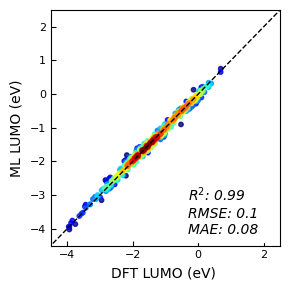

>>>>>> Val set (214,)
R square score:  0.9940119067627142
RMSE, MAE: 0.10129359844322468 0.07598392953102813


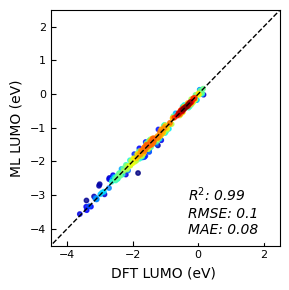

>>>>>> Val set (13,)
R square score:  0.9941429143953784
RMSE, MAE: 0.058267476513596435 0.041520145931490705


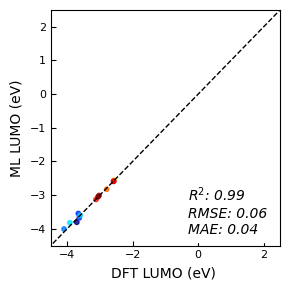

,Dataset size,R2,RMSE,MAE
0,329,0.99,0.10,0.08
1,214,0.99,0.10,0.08
2,13,0.99,0.06,0.04


,Dataset size,R2,RMSE,MAE
0,1.00,1.00,1.00,1.00
1,0.65,1.00,1.00,1.00
2,0.04,1.00,0.60,0.50


In [101]:
scaler_all = df_prop['scaler']

plot_together = []
for n in use_index:
    x = scaler_all.transform( all_prop[n]['x_val'] )
    r2,rmse,mae = score_val( x, all_prop[n]['y_val']['LUMO'],  model_all, name='', axs_lim=[-4.5,2.5], alpha=0.8, savefig=f'training_{n}.png')
    plot_together.append( [len(all_prop[n]['x_val']),r2,rmse,mae] )
plot_together = pd.DataFrame(plot_together, columns=['Dataset size','R2','RMSE','MAE'])
plot_together = plot_together.sort_values(by='Dataset size',ascending=False).reset_index(drop=True)

df_plot = plot_together.copy()
#df_plot = plot_together - plot_together.min()
df_plot = df_plot/df_plot.max()
#df_plot += 0.1
display( plot_together, df_plot )


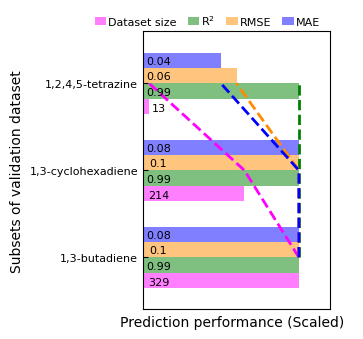

In [107]:
fig, axs = plt.subplots(1,1, figsize=(3.5,3.5), tight_layout=True)
#ax2 = axs.twinx()
colors = ['magenta','green','darkorange','b']
df_plot.plot(kind='barh', stacked=False, y=['Dataset size','R2','RMSE','MAE'], ax=axs, color=colors,
             width=0.7, alpha=0.5
            )

y = list( df_plot.index )
for i,(c,c1) in enumerate(zip(df_plot.columns,plot_together.columns)):
    axs.plot(df_plot[c],y, '--', color=colors[i], lw=2, alpha=1)
    num = [ str(s) for s in plot_together[c1]]
    for cx,cy,cm in zip(df_plot[c],y,num):
        axs.text( 0.1,cy+(i-1.55)*0.18,cm, ha='center', va='center', fontsize=8, color='k') # x=cx+0.1
    
axs.set_xlabel('Prediction performance (Scaled)  ',fontsize=10) ## input X name
axs.set_ylabel('Subsets of validation dataset',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize=8)
axs.set_yticklabels(  ['1,3-butadiene','1,3-cyclohexadiene','1,2,4,5-tetrazine'] )
axs.set_xlim([0,1.2])
axs.set_xticks( [] )

legend = axs.get_legend()
handles = legend.legendHandles
#legend.remove()
axs.legend(handles, ['Dataset size',r'R$^2$','RMSE','MAE'], fontsize=8, frameon=False, loc=0, ncol=4,
          bbox_to_anchor=(1,1.1), handlelength=1, handletextpad=0.2, columnspacing=1
          )

plt.subplots_adjust(left=0.15, right=0.9, top=0.95, bottom=0.1)

plt.savefig("Validating_BreakDown.png", dpi=800)      
plt.show()

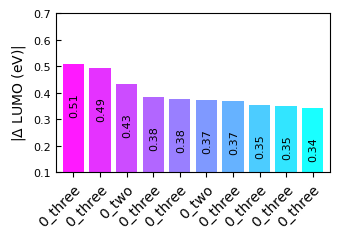

In [108]:
error_bar = pd.DataFrame()
labels = []

df_sr = y_train_predict - df_prop['y_train']['LUMO']
error_bar = pd.concat( [error_bar,df_sr.to_frame()], axis=0 )
labels += list(df_prop['y_train']['diene_type'])

df_sr = y_test_predict - df_prop['y_test']['LUMO']
error_bar = pd.concat( [error_bar,df_sr.to_frame()], axis=0 )
labels += list(df_prop['y_test']['diene_type'])

df_sr = y_val_predict - df_prop['y_val']['LUMO']
error_bar = pd.concat( [error_bar,df_sr.to_frame()], axis=0 )
labels += list(df_prop['y_val']['diene_type'])

error_bar = error_bar.abs().sort_values(by='LUMO', ascending=False)

df_plot = error_bar.head(10)
labels = labels[:10]

#labels = list( df_plot.index.str.capitalize() )
#labels[-1] = 'Others'
fig, axs = plt.subplots(1,1,figsize=(3.5,2.5),tight_layout=True,dpi=100)
#colors = ['magenta','green','darkorange','b','r']
cmap = plt.get_cmap('cool')
colors = cmap(np.linspace(1, 0, 10))

bars = df_plot.plot(kind='bar', stacked=False, y=['LUMO'], ax=axs, #xlabel=labels, #color=colors,
             width=0.8, alpha=0.9)
#for ii,container in enumerate(axs.containers):
#    container.datavalues[0]=-1
#    axs.bar_label(container, rotation=90, fontsize=8, padding=-30 ) #label_type='center')
for n,rect in enumerate(axs.patches):
    x = rect.get_x()
    y = rect.get_height()
    rect.set_fc( colors[n] )
    axs.text(x+0.25,y-0.2,str(round(y,2)), ha='left', va='bottom', fontsize=8, color='k', rotation=90) # x=cx+0.1
    
axs.set_xlabel(None,fontsize=10) ## input X name
axs.set_ylabel(r'|$\Delta$ LUMO (eV)|' ,fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize=8, axis='y')
axs.set_xticklabels( labels, rotation=45, fontsize=10, ha='right', rotation_mode='anchor')
axs.set_ylim([0.1,0.7])
#axs.set_xticks( [] )
axs.legend().set_visible(False) #labels=['Aliphatic']+ring_names, fontsize=8, frameon=False, ncol=2, handlelength=1, handletextpad=0.2, columnspacing=1)
#plt.yscale('log')

plt.savefig("ErrorBar.png", dpi=800)  
plt.show()

In [136]:
fp_name_prop = list( df_prop['x_train'].columns )
print( fp_name_prop )

scaler_all = df_prop['scaler']
print( scaler_all )

import joblib
import json

file_model = 'model_final.pkl'
joblib.dump(model_all, file_model)

file_scaler = f'scaler_final.pkl'
joblib.dump(scaler_all, file_scaler)

file_feature='feature_final.json'
with open(file_feature, 'w') as f1:
    json.dump(fp_name_prop, f1, indent=4)
    

['rdk_MaxEStateIndex', 'rdk_MinAbsEStateIndex', 'rdk_FpDensityMorgan1', 'rdk_FpDensityMorgan3', 'rdk_BalabanJ', 'rdk_BertzCT', 'rdk_Chi2n', 'rdk_Chi3v', 'rdk_HallKierAlpha', 'rdk_Kappa3', 'rdk_PEOE_VSA1', 'rdk_PEOE_VSA10', 'rdk_PEOE_VSA11', 'rdk_PEOE_VSA12', 'rdk_PEOE_VSA13', 'rdk_PEOE_VSA14', 'rdk_PEOE_VSA2', 'rdk_PEOE_VSA6', 'rdk_PEOE_VSA7', 'rdk_PEOE_VSA8', 'rdk_PEOE_VSA9', 'rdk_SMR_VSA1', 'rdk_SMR_VSA10', 'rdk_SMR_VSA2', 'rdk_SMR_VSA3', 'rdk_SMR_VSA6', 'rdk_SMR_VSA7', 'rdk_SlogP_VSA10', 'rdk_SlogP_VSA11', 'rdk_SlogP_VSA12', 'rdk_SlogP_VSA2', 'rdk_EState_VSA2', 'rdk_EState_VSA3', 'rdk_EState_VSA4', 'rdk_EState_VSA5', 'rdk_EState_VSA6', 'rdk_EState_VSA7', 'rdk_EState_VSA8', 'rdk_EState_VSA9', 'rdk_VSA_EState10', 'rdk_VSA_EState2', 'rdk_VSA_EState3', 'rdk_VSA_EState4', 'rdk_VSA_EState7', 'rdk_VSA_EState8', 'rdk_NHOHCount', 'rdk_NumHeteroatoms', 'rdk_NumRotatableBonds', 'rdk_MolLogP', 'COS']
StandardScaler()


In [152]:
import joblib
import json

model_all = joblib.load('model_final.pkl')
scaler_all = joblib.load('scaler_final.pkl')
with open('feature_final.json', 'r') as f1:
    fp_name_prop = json.load(f1)

In [153]:
## Make prdiction on  new data point
### pubchem, rdkprop, padelpy
from padelpy import from_smiles

def predict_padelpy(smi, fp_name, model, output_padelpy_descriptor=False, output_pubchem_fingerprint=True):
    """
    The default is to output pubchem fp and not padel descriptor
    """
    fp = from_smiles(smi, 
                     fingerprints=output_pubchem_fingerprint, 
                     descriptors=output_padelpy_descriptor
                    )
    if isinstance(smi, list):
        fp_col = list(fp[0].keys())
        fp_data = [list(f.values()) for f in fp ]
        df_fps = pd.DataFrame( data=fp_data, columns=fp_col )
    elif isinstance(smi, str):
        fp_col = list(fp.keys())
        fp_data = list(fp.values())
        df_fps = pd.DataFrame( data=[fp_data], columns=fp_col )
    df_fps = df_fps[fp_name]
    predict_new = model.predict(df_fps)
    return predict_new

from tqdm import tqdm
from time import sleep

def predict_rdk_prop(smi, fp_full_name, model, scaler=None, fp_calc=None):
    """
    smi: diene SMILES 
    fp_calc: the calculator 
    fp_name: the final fingerprint list for ML 
    model: trained model
    """
    fp_name = [ f.replace('rdk_','') for f in fp_full_name]
    if fp_calc==None:
        fp_calc = MoleculeDescriptors.MolecularDescriptorCalculator(fp_name)
    if isinstance(smi, list):
        fp_molecule = []
        for n, (i,s) in enumerate(zip( tqdm(range(len(smi))), smi )):
            if n%int(len(smi)/5)==0:
                display( f'{n} out of {len(smi)}' )
            #display( sleep(0.000000001) )
            fp = list( fp_calc.CalcDescriptors( Chem.MolFromSmiles(s) ) )
            fp_molecule.append(fp)
        #fp_molecule = [list( fp_calc.CalcDescriptors( Chem.MolFromSmiles(s) ) ) for s in smi]
        new_df = pd.DataFrame( data=fp_molecule, columns=fp_full_name )
        if scaler is not None:
            new_df = scaler.transform(new_df)
        predict_new = model.predict(new_df)
    else:
        print('Error')
    return predict_new


In [154]:
df_prediction = pd.read_csv('df_prediction.csv', index_col=0)
df_parameterization = pd.read_csv('df_parameterization.csv', index_col=0)
#display(df_prediction, df_parameterization) 

In [155]:
%%capture --no-display

prediction1 = predict_rdk_prop( list(df_prediction.index), fp_name_prop, model_all, scaler=scaler_all)
df_prediction['LUMO_predicted'] = prediction1
df_prediction = df_prediction.sort_values(by='LUMO_predicted',ascending=True)
#df_qm9.to_csv('Old_all_dienes_PredLUMO.csv')

df_prediction = df_prediction[['LUMO','diene_type','LUMO_predicted']]
df_prediction

'0 out of 3060'

'612 out of 3060'

'1224 out of 3060'

'1836 out of 3060'

'2448 out of 3060'

,LUMO,diene_type,LUMO_predicted
[H]C(=O)/C(C#N)=C(\C#N)C([H])=C([H])[H],-4.16,0_three,-4.05
[H]C(=O)/C([H])=C(C#N)/C([H])=C(\[H])C([H])=O,-4.12,0_three,-4.04
[H]C(=O)C(=C([H])[H])C([H])=C(C#N)C#N,-3.75,0_three,-4.02
[H]OC(=O)/C(C#N)=C([H])\C([H])=C(/[H])C([H])=O,-3.88,0_three,-4.00
[H]C(=O)C(=C([H])[H])/C([H])=C(/C#N)C([H])=O,-3.69,0_three,-3.98
...,...,...,...
[H]/C(=C(C(\[H])=C(/[H])N(C([H])([H])[H])C([H])([H])[H])/N(C([H])([H])[H])C([H])([H])[H])N([H])[H],0.41,0_three,0.33
[H]OC1=C([H])C(N(C([H])([H])[H])C([H])([H])[H])=C(N(C([H])([H])[H])C([H])([H])[H])C([H])([H])C1([H])[H],-0.10,1_three,0.35
[H]C(=C(OC([H])([H])[H])OC([H])([H])[H])/C([H])=C(\[H])N([H])[H],0.72,0_three,0.42
[H]C(=C(\N([H])[H])N(C([H])([H])[H])C([H])([H])[H])/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H])[H],0.40,0_three,0.42


In [156]:
%%capture --no-display

prediction1 = predict_rdk_prop( list(df_parameterization.index), fp_name_prop, model_all, scaler=scaler_all)
df_parameterization['LUMO_predicted'] = prediction1
df_parameterization = df_parameterization.sort_values(by='LUMO_predicted',ascending=True)
#df_qm9.to_csv('Old_all_dienes_PredLUMO.csv')

df_parameterization = df_parameterization[['LUMO','diene_type','LUMO_predicted']]
df_parameterization

'0 out of 2779'

'555 out of 2779'

'1110 out of 2779'

'1665 out of 2779'

'2220 out of 2779'

'2775 out of 2779'

,LUMO,diene_type,LUMO_predicted
[H]C(=O)c1nnc(C#N)nn1,-4.30,2_two,-4.35
N#Cc1nnc(C#N)nn1,-4.55,2_two,-4.34
[H]O[S@+]([O-])c1nnc(C#N)nn1,-4.19,2_two,-4.28
[H]OC(=O)c1nnc(C#N)nn1,-4.12,2_two,-4.23
[H]C(=O)c1nnc(C([H])=O)nn1,-4.16,2_two,-4.16
...,...,...,...
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H])C([H])([H])[H])=C(/[H])N(C([H])([H])[H])C([H])([H])[H],0.98,0_three,0.39
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H])[H])=C(/[H])N([H])[H],0.69,0_two,0.46
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])([H])[H])/C([H])=C(\[H])N([H])[H],0.77,0_three,0.46
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H],0.83,0_two,0.51


>>>>>> Val set (13, 3)
Pearsons correlation: 0.965
R square score:  0.9287175934865651
RMSE, MAE: 0.26000713742814674 0.20406617963918666


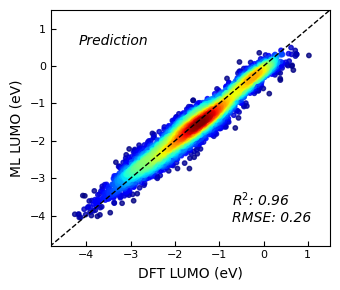

In [162]:
#sns.scatterplot(data=df_old, x=, y=)
fig, axs = plt.subplots(1,1,figsize=(3.5,3),tight_layout=True )#,dpi=100)

x,y = df_prediction["LUMO"], df_prediction["LUMO_predicted"]
x,y,z = color_density(x,y)

#z = plt.cm.jet(z)            
a, b = np.polyfit(x, y, 1)
#x = a*x + b
im = axs.scatter(x, y, marker='o', c=z, cmap='jet', label='Validating', alpha=0.8, s=10)     

axs.plot([-100,100], [-100,100], '--', color='k', lw=1)

corr, _ = stats.pearsonr( x, y )
r2_val = metrics.r2_score(x, y)
rmse_val = np.sqrt(metrics.mean_squared_error(x, y))    
mae_val = metrics.mean_absolute_error(x, y)
print(">>>>>> Val set", y_val.shape)
print('Pearsons correlation: %.3f' % corr)
print("R square score: " , r2_val)
print("RMSE, MAE:", rmse_val, mae_val)

axlim = [-4.8, 1.5]
#ax_min = np.amin([np.amin(x), np.amin(y)])-0.1
#ax_max = np.amax([np.amax(x), np.amax(y)])+0.1
axs.set_xlim(axlim)
axs.set_ylim(axlim)
axs.set_xlabel('DFT LUMO (eV)', fontsize=10)
axs.set_ylabel('ML LUMO (eV)', fontsize=10)
axs.tick_params(direction='in',labelsize=8)

r2_val, rmse_val, mae_val = np.round([corr, rmse_val, mae_val], 2)
performance = f'R$^2$: {r2_val}\nRMSE: {rmse_val}'#\nMAE: {mae_val}'
axs.text(0.65,0.1, performance, style='italic', fontsize=10, transform = axs.transAxes, backgroundcolor='white', color='k')
axs.text(0.1, 0.85, 'Prediction', style='italic', fontsize=10, transform = axs.transAxes, backgroundcolor='white', color='k')
    
#axs.legend(fontsize=8, frameon=False,)
plt.savefig('prediction_in_dataset.png', dpi=800) 

>>>>>> Val set (13, 3)
R square score:  0.9819837225747815
RMSE, MAE: 0.12665012020152336 0.09924508967430413


Text(0.6, 0.05, 'R$^2$: 0.98\nRMSE: 0.13\nMAE: 0.1')

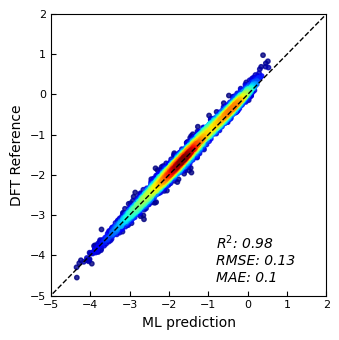

In [146]:
#sns.scatterplot(data=df_old, x=, y=)
fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True )#,dpi=100)

y,x = df_parameterization["LUMO"], df_parameterization["LUMO_predicted"]
x,y,z = color_density(x,y)

#z = plt.cm.jet(z)            
a, b = np.polyfit(x, y, 1)
#x = a*x + b
im = axs.scatter(x, y, marker='o', c=z, cmap='jet', label='Validating', alpha=0.8, s=10)     

axs.plot([-100,100], [-100,100], '--', color='k', lw=1)

r2_val = metrics.r2_score(x, y)
rmse_val = np.sqrt(metrics.mean_squared_error(x, y))    
mae_val = metrics.mean_absolute_error(x, y)
print(">>>>>> Val set", y_val.shape)
print("R square score: " , r2_val)
print("RMSE, MAE:", rmse_val, mae_val)

ax_min = np.amin([np.amin(x), np.amin(y)])-0.1
ax_max = np.amax([np.amax(x), np.amax(y)])+0.1
ax_min,ax_max = -5,2
axs.set_xlim((ax_min,ax_max))
axs.set_ylim((ax_min,ax_max))
    
axs.set_ylabel('DFT Reference',fontsize=10) ## input X name
axs.set_xlabel('ML prediction',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize=8)

r2_val, rmse_val, mae_val = np.round([r2_val, rmse_val, mae_val], 2)
performance = f'R$^2$: {r2_val}\nRMSE: {rmse_val}\nMAE: {mae_val}'
axs.text(0.6,0.05, performance, style='italic', fontsize=10, transform = axs.transAxes, backgroundcolor='white', color='k')
    
#axs.legend(fontsize=8, frameon=False,)
#plt.savefig(savefig, dpi=800) 

,LUMO,diene_type,LUMO_predicted,err
[H]C(=O)C1=C([H])C([H])([H])C([H])([H])C(N([H])[H])=C1C([H])=O,-1.67,1_three,-2.74,1.07
[H]OC(=O)/C(O[H])=C(/[H])C(OC([H])([H])[H])=C([H])[H],-0.64,0_three,-1.66,1.02
[H]OC(=O)C(=C(/[H])N(C([H])([H])[H])C([H])([H])[H])/C([H])=C(\[H])C#N,-1.56,0_three,-2.44,0.87
[H]C([H])=C(SC([H])([H])[H])/C(=C(/[H])C([H])([H])[H])C([H])([H])[H],0.13,0_three,-0.74,0.87
[H]OC(=O)C1=C(N([H])[H])C([H])([H])C([H])([H])C([H])=C1C#N,-1.49,1_three,-2.35,0.85
[H]OC(=O)/C(C([H])=C([H])[H])=C(\OC([H])([H])[H])N([H])[H],-0.56,0_three,-1.39,0.82
[H]OC(=O)/C([H])=C(/C#N)C(=C([H])[H])N([H])[H],-3.03,0_three,-2.22,0.82
[H]C(=O)/C(C(C#N)=C([H])[H])=C(\[H])N(C([H])([H])[H])C([H])([H])[H],-1.78,0_three,-2.59,0.81
[H]O[S@+]([O-])C1=C(N(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])=C1C([H])=O,-1.66,1_three,-2.46,0.80
[H]C(=O)C1=C(N([H])[H])C([H])([H])C([H])([H])C(C([H])=O)=C1[H],-1.94,1_three,-2.74,0.80


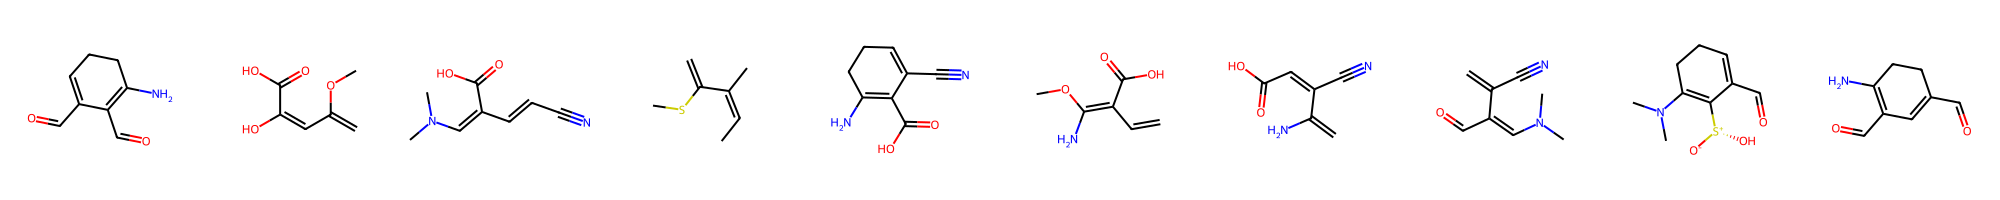

In [147]:
err = df_prediction["LUMO"]-df_prediction["LUMO_predicted"]
df_prediction['err'] = err.abs() 
df = df_prediction.sort_values(by=['err'], ascending=False)

display( df.head(10) )
img1 = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in df.head(10).index ], molsPerRow=10,  )
img1

# ML screening

In [73]:
import joblib
import json

from tqdm import tqdm
from time import sleep

model_all = joblib.load('model_final.pkl')
scaler_all = joblib.load('scaler_final.pkl')
with open('feature_final.json', 'r') as f1:
    fp_name_prop = json.load(f1)
    
def predict_rdk_prop(smi, fp_full_name, model, scaler=None, fp_calc=None):
    fp_name = [ f.replace('rdk_','') for f in fp_full_name]
    if fp_calc==None:
        fp_calc = MoleculeDescriptors.MolecularDescriptorCalculator(fp_name)
    if isinstance(smi, list):
        fp_molecule = []
        for n, (i,s) in enumerate(zip( tqdm(range(len(smi))), smi )):
            if n%int(len(smi)/5)==0:
                display( f'{n} out of {len(smi)}' )
            #display( sleep(0.000000001) )
            fp = list( fp_calc.CalcDescriptors( Chem.MolFromSmiles(s) ) )
            fp_molecule.append(fp)
        #fp_molecule = [list( fp_calc.CalcDescriptors( Chem.MolFromSmiles(s) ) ) for s in smi]
        new_df = pd.DataFrame( data=fp_molecule, columns=fp_full_name )
        if scaler is not None:
            new_df = scaler.transform(new_df)
        predict_new = model.predict(new_df)
    else:
        print('Error')
    return predict_new

In [74]:
job_csv = [f for f in os.listdir('./') if 'new_dinene_' in f ]
job_csv

['new_dinene_four_func_0.csv',
 'new_dinene_four_func_1.csv',
 'new_dinene_one_func_0.csv',
 'new_dinene_one_func_1.csv',
 'new_dinene_one_func_2.csv',
 'new_dinene_three_func_0.csv',
 'new_dinene_three_func_1.csv',
 'new_dinene_two_func_0.csv',
 'new_dinene_two_func_1.csv',
 'new_dinene_two_func_2.csv']

In [75]:
df_new = pd.DataFrame()
for j in job_csv:
    df = pd.read_csv( j, index_col=0)
    j = j[11:-4].split('_')
    df['source'] = j[-1]+'_'+j[0].replace('one','1').replace('two','2').replace('three','3') # x_y means diene_#group
    df_new = pd.concat( [df_new, df], axis=0, ignore_index=True )
df_new

,SMILES,INCHI,source
0,C=CC(=C)O,"InChI=1S/C4H6O/c1-3-4(2)5/h3,5H,1-2H2",0_1
1,C=CC=CO,"InChI=1S/C4H6O/c1-2-3-4-5/h2-5H,1H2",0_1
2,C=CC=CNC,"InChI=1S/C5H9N/c1-3-4-5-6-2/h3-6H,1H2,2H3",0_1
3,C=CC(=C)NC,"InChI=1S/C5H9N/c1-4-5(2)6-3/h4,6H,1-2H2,3H3",0_1
4,C=CC=CN(C)C,"InChI=1S/C6H11N/c1-4-5-6-7(2)3/h4-6H,1H2,2-3H3",0_1
...,...,...,...
47555,CNC(=O)c1nnc([N+](=O)[O-])nn1,InChI=1S/C4H4N6O3/c1-5-3(11)2-6-8-4(9-7-2)10(1...,2_2
47556,O=[N+]([O-])c1nnc(CO)nn1,InChI=1S/C3H3N5O3/c9-1-2-4-6-3(7-5-2)8(10)11/h...,2_2
47557,CNC(=O)c1nnc(C(=O)NC)nn1,InChI=1S/C6H8N6O2/c1-7-5(13)3-9-11-4(12-10-3)6...,2_2
47558,CNC(=O)c1nnc(CO)nn1,InChI=1S/C5H7N5O2/c1-6-5(12)4-9-7-3(2-11)8-10-...,2_2


In [76]:
%%capture --no-display

df = df_new.copy()
display( df_new.value_counts('source') )

prediction1 = predict_rdk_prop( list(df['SMILES']), fp_name_prop, model_all, scaler=scaler_all )
df['LUMO_predicted'] = prediction1
df = df.sort_values(by='LUMO_predicted',ascending=True)
display( df )

source
0_3    28600
1_3    16000
0_2     1430
1_2     1220
2_2      210
0_1       40
1_1       40
2_1       20
Name: count, dtype: int64

'0 out of 47560'

'9512 out of 47560'

'19024 out of 47560'

'28536 out of 47560'

'38048 out of 47560'

,SMILES,INCHI,source,LUMO_predicted
47498,N#Cc1nnc(C=O)nn1,InChI=1S/C4HN5O/c5-1-3-6-8-4(2-10)9-7-3/h2H,2_2,-4.35
47532,N#Cc1nnc(C#N)nn1,InChI=1S/C4N6/c5-1-3-7-9-4(2-6)10-8-3,2_2,-4.34
47536,N#Cc1nnc([N+](=O)[O-])nn1,InChI=1S/C3N6O2/c4-1-2-5-7-3(8-6-2)9(10)11,2_2,-4.26
47534,N#Cc1nnc(S(=O)O)nn1,InChI=1S/C3HN5O2S/c4-1-2-5-7-3(8-6-2)11(9)10/h...,2_2,-4.24
47517,N#Cc1nnc(C(=O)O)nn1,InChI=1S/C4HN5O2/c5-1-2-6-8-3(4(10)11)9-7-2/h(...,2_2,-4.23
...,...,...,...,...
8116,CC(=CC=CN)N(C)C,"InChI=1S/C7H14N2/c1-7(9(2)3)5-4-6-8/h4-6H,8H2,...",0_3,0.45
44975,CN(C)C=CC=CN,"InChI=1S/C6H12N2/c1-8(2)6-4-3-5-7/h3-6H,7H2,1-2H3",0_2,0.46
8095,CN(C)C=CC=C(N)N,"InChI=1S/C6H13N3/c1-9(2)5-3-4-6(7)8/h3-5H,7-8H...",0_3,0.49
45096,NC=CC=CN,"InChI=1S/C4H8N2/c5-3-1-2-4-6/h1-4H,5-6H2",0_2,0.51


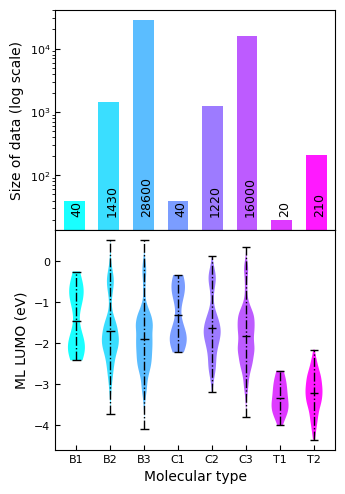

In [78]:
df_plot = df.value_counts('source').sort_index(inplace=False) 
customized_label = ['B1','B2','B3','C1','C2','C3','T1','T2']

fig, axs = plt.subplots( 2, 1, figsize=(3.5,5), )#tight_layout=True, dpi=100)

#colors = ['magenta','green','darkorange','b','r']
cmap = plt.get_cmap('cool')
colors = cmap(np.linspace(0, 1, len(df_plot)))

df_plot.plot(kind='bar', stacked=False, ax=axs[0], color=colors,
             width=0.6, alpha=0.9)
#for ii,container in enumerate(axs.containers):
#    container.datavalues[0]=-1
#    axs.bar_label(container, rotation=90, fontsize=8, padding=-30 ) #label_type='center')
for n,rect in enumerate(axs[0].patches):
    x = rect.get_x()
    y = rect.get_height()
    rect.set_fc( colors[n] )
    axs[0].text(x+0.2, 22, str(int(y)), ha='left', va='bottom', fontsize=9, color='k', rotation=90) # x=cx+0.1

axs[0].set_yscale('log')
axs[0].set_ylabel('Size of data (log scale)',fontsize=10) ## input Y name
axs[0].set_xlabel(None) 
axs[0].tick_params(direction='out',labelsize=8, )#axis='y')
axs[0].set_xticklabels( [] )
axs[0].set_xticks( [] )
axs[0].tick_params(direction='in',labelsize=8)
#axs.set_xlim([-0.5,4.5])
#axs.legend(labels=customized_label, fontsize=8, frameon=False, ncol=2, handlelength=1, handletextpad=0.2, columnspacing=1)


names_new = sorted( list(set(df['source'])) )
df_source = [ df[df['source']==m] for m in names_new ]
parts = axs[1].violinplot( [ d['LUMO_predicted'] for d in df_source ], showmeans=True)

for i,p in enumerate(parts['bodies']):
    p.set_facecolor(colors[i])
    p.set_edgecolor('None')
    p.set_alpha(0.9)
    #p.set_linewidth(0.1)
for k in ['cbars','cmins','cmaxes','cmeans']:
    parts[k].set_colors('k')    
    parts[k].set_linewidth(1)
    parts[k].set_linestyles('-.')
    
axs[1].set_xlabel('Molecular type', fontsize=10)
axs[1].set_ylabel('ML LUMO (eV)', fontsize=10)
axs[1].tick_params(direction='in',labelsize=8)
axs[1].set_xticks( [n+1 for n in range(len(df_source)) ] ,labels=customized_label)
#axs.legend(labels=customized_label, fontsize=8, frameon=False, loc=2)
#axs.set_ylim(top=25)

plt.subplots_adjust(wspace=0, hspace=0.0)
plt.subplots_adjust(left=0.15, right=0.95, top=0.98, bottom=0.1)

plt.savefig("prediction_new_data_distribution.png", dpi=800)  
#plt.savefig("poplation.png", dpi=800)  
plt.show()


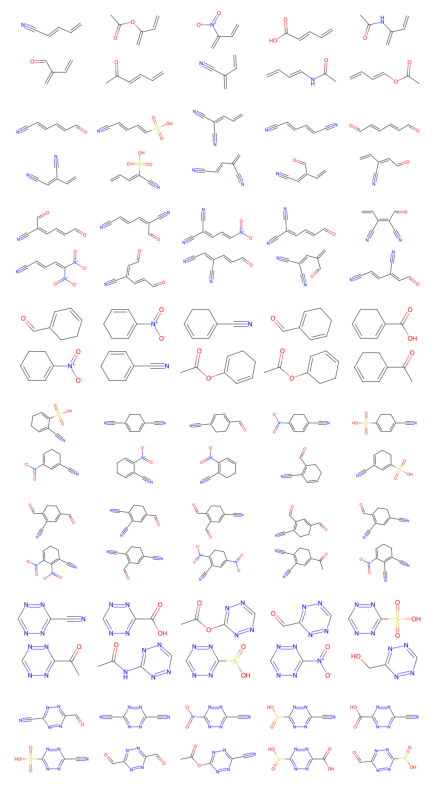

,SMILES,INCHI,source,LUMO_predicted
26,C=CC=CC#N,"InChI=1S/C5H5N/c1-2-3-4-5-6/h2-4H,1H2",0_1,-2.41
15,C=CC(=C)OC(C)=O,"InChI=1S/C6H8O2/c1-4-5(2)8-6(3)7/h4H,1-2H2,3H3",0_1,-2.35
34,C=CC(=C)[N+](=O)[O-],"InChI=1S/C4H5NO2/c1-3-4(2)5(6)7/h3H,1-2H2",0_1,-2.29
22,C=CC=CC(=O)O,"InChI=1S/C5H6O2/c1-2-3-4-5(6)7/h2-4H,1H2,(H,6,7)",0_1,-2.24
12,C=CC(=C)NC(C)=O,"InChI=1S/C6H9NO/c1-4-5(2)7-6(3)8/h4H,1-2H2,3H3...",0_1,-2.23
...,...,...,...,...
47535,N#Cc1nnc(S(=O)(=O)O)nn1,"InChI=1S/C3HN5O3S/c4-1-2-5-7-3(8-6-2)12(9,10)1...",2_2,-4.21
47494,O=Cc1nnc(C=O)nn1,InChI=1S/C4H2N4O2/c9-1-3-5-7-4(2-10)8-6-3/h1-2H,2_2,-4.16
47475,CC(=O)Oc1nnc(C#N)nn1,InChI=1S/C5H3N5O2/c1-3(11)12-5-9-7-4(2-6)8-10-...,2_2,-4.12
47519,O=C(O)c1nnc(S(=O)O)nn1,InChI=1S/C3H2N4O4S/c8-2(9)1-4-6-3(7-5-1)12(10)...,2_2,-4.10


In [87]:
df_new_xyz = pd.DataFrame()

names_new = sorted( list(set(df['source'])) )
fig, axs = plt.subplots( len(names_new), 1, figsize=(6,8), tight_layout=True, dpi=100)

for n,m in enumerate(names_new):
    d = df[ df['source']==m ]
    img1 = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in d.head(10)['SMILES'] ], molsPerRow=5,  
                               subImgSize=(400, 200), returnPNG=False, )
                               #legends=[str(round(e,2)) for e in d.head(10)['LUMO_predicted']] )
    #display( d.head(10), img1 )
    axs[n].imshow(img1)
    axs[n].axis('off')
    #img1.save(f'new_XYZ_snapshot_{m}.png')
    df_new_xyz = pd.concat( [df_new_xyz, d.head(10)], axis=0)
plt.savefig("new_XYZ_snapshot_all.png", dpi=800) 
plt.show()    
#df_new_xyz.to_csv('df_new_xyz.csv') 

df_new_xyz  
   

In [86]:
## Convert SMILES to XYZ

def smiles_to_xyz_pybel(smi, if_write_xyz='molecule.xyz', if_overwrite=False):
    mol = pybel.readstring("smi", smi)
    mol.addh() # add Hs for 3D
    mol.make3D() # generate 3D coordinates
    if if_write_xyz is not None:
        xyz = mol.write(format='xyz',filename=if_write_xyz, overwrite=if_overwrite)
    else:
        xyz = mol.write(format='xyz')
    return xyz


os.makedirs('New_XYZ', exist_ok=True)
new_col = []
for n, (s,m) in enumerate(zip( df_new_xyz['SMILES'],df_new_xyz['source'] )):
    xyz_name = f'pybel_{m}_{n}.xyz'
    smiles_to_xyz_pybel( s, if_write_xyz=os.path.join('New_XYZ', xyz_name) )
    new_col.append( xyz_name )
    #mol = Chem.AddHs( Chem.MolFromSmiles(s) )
    #xyz_name = f'rdkit_{m}_{n}.xyz'
    #Chem.rdmolfiles.MolToXYZFile(mol, os.path.join('New_XYZ', xyz_name) )
df_new_xyz['xyz_name'] = new_col
df_new_xyz.to_csv('df_new_xyz.csv')
df_new_xyz           

,SMILES,INCHI,source,LUMO_predicted,xyz_name
26,C=CC=CC#N,"InChI=1S/C5H5N/c1-2-3-4-5-6/h2-4H,1H2",0_1,-2.41,pybel_0_1_0.xyz
15,C=CC(=C)OC(C)=O,"InChI=1S/C6H8O2/c1-4-5(2)8-6(3)7/h4H,1-2H2,3H3",0_1,-2.35,pybel_0_1_1.xyz
34,C=CC(=C)[N+](=O)[O-],"InChI=1S/C4H5NO2/c1-3-4(2)5(6)7/h3H,1-2H2",0_1,-2.29,pybel_0_1_2.xyz
22,C=CC=CC(=O)O,"InChI=1S/C5H6O2/c1-2-3-4-5(6)7/h2-4H,1H2,(H,6,7)",0_1,-2.24,pybel_0_1_3.xyz
12,C=CC(=C)NC(C)=O,"InChI=1S/C6H9NO/c1-4-5(2)7-6(3)8/h4H,1-2H2,3H3...",0_1,-2.23,pybel_0_1_4.xyz
...,...,...,...,...,...
47535,N#Cc1nnc(S(=O)(=O)O)nn1,"InChI=1S/C3HN5O3S/c4-1-2-5-7-3(8-6-2)12(9,10)1...",2_2,-4.21,pybel_2_2_75.xyz
47494,O=Cc1nnc(C=O)nn1,InChI=1S/C4H2N4O2/c9-1-3-5-7-4(2-10)8-6-3/h1-2H,2_2,-4.16,pybel_2_2_76.xyz
47475,CC(=O)Oc1nnc(C#N)nn1,InChI=1S/C5H3N5O2/c1-3(11)12-5-9-7-4(2-6)8-10-...,2_2,-4.12,pybel_2_2_77.xyz
47519,O=C(O)c1nnc(S(=O)O)nn1,InChI=1S/C3H2N4O4S/c8-2(9)1-4-6-3(7-5-1)12(10)...,2_2,-4.10,pybel_2_2_78.xyz


,SMILES,INCHI,source,LUMO_predicted,LUMO_DFT,Energy_DFT
xyz_name,,,,,,
pybel_0_1_2.xyz,C=CC(=C)[N+](=O)[O-],"InChI=1S/C4H5NO2/c1-3-4(2)5(6)7/h3H,1-2H2",0_1,-2.29,-2.83,-360.46
pybel_0_1_0.xyz,C=CC=CC#N,"InChI=1S/C5H5N/c1-2-3-4-5-6/h2-4H,1H2",0_1,-2.41,-2.29,-248.20
pybel_0_1_6.xyz,C=CC=CC(C)=O,"InChI=1S/C6H8O/c1-3-4-5-6(2)7/h3-5H,1H2,2H3",0_1,-2.22,-2.26,-308.60
pybel_0_1_3.xyz,C=CC=CC(=O)O,"InChI=1S/C5H6O2/c1-2-3-4-5(6)7/h2-4H,1H2,(H,6,7)",0_1,-2.24,-2.14,-344.54
pybel_0_1_5.xyz,C=CC(=C)C=O,"InChI=1S/C5H6O/c1-3-5(2)4-6/h3-4H,1-2H2",0_1,-2.22,-2.09,-269.28


,SMILES,INCHI,source,LUMO_predicted,LUMO_DFT,Energy_DFT
xyz_name,,,,,,
pybel_0_2_18.xyz,C=CC(C=O)=CC#N,"InChI=1S/C6H5NO/c1-2-6(5-8)3-4-7/h2-3,5H,1H2",0_2,-3.32,-3.48,-361.51
pybel_0_2_15.xyz,C=CC(C#N)=CC#N,"InChI=1S/C6H4N2/c1-2-6(5-8)3-4-7/h2-3H,1H2",0_2,-3.37,-3.43,-340.42
pybel_0_2_12.xyz,C=CC=C(C#N)C#N,"InChI=1S/C6H4N2/c1-2-3-6(4-7)5-8/h2-3H,1H2",0_2,-3.52,-3.39,-340.42
pybel_0_2_14.xyz,O=CC=CC=CC=O,InChI=1S/C6H6O2/c7-5-3-1-2-4-6-8/h1-6H,0_2,-3.37,-3.37,-382.61
pybel_0_2_10.xyz,N#CC=CC=CC=O,"InChI=1S/C6H5NO/c7-5-3-1-2-4-6-8/h1-4,6H",0_2,-3.71,-3.36,-361.52


,SMILES,INCHI,source,LUMO_predicted,LUMO_DFT,Energy_DFT
xyz_name,,,,,,
pybel_0_3_22.xyz,N#CC(C#N)=CC=C[N+](=O)[O-],InChI=1S/C6H3N3O2/c7-4-6(5-8)2-1-3-9(10)11/h1-3H,0_3,-4.08,-4.45,-544.93
pybel_0_3_25.xyz,N#CC=CC=C([N+](=O)[O-])[N+](=O)[O-],InChI=1S/C5H3N3O4/c6-4-2-1-3-5(7(9)10)8(11)12/...,0_3,-4.04,-4.34,-657.19
pybel_0_3_24.xyz,C=CC(C#N)=C(C#N)C=O,"InChI=1S/C7H4N2O/c1-2-6(3-8)7(4-9)5-10/h2,5H,1H2",0_3,-4.05,-4.16,-453.73
pybel_0_3_26.xyz,N#CC(C=CC=O)=CC=O,InChI=1S/C7H5NO2/c8-6-7(3-5-10)2-1-4-9/h1-5H,0_3,-4.04,-4.12,-474.83
pybel_0_3_23.xyz,N#CC(C#N)=CC=CC=O,InChI=1S/C7H4N2O/c8-5-7(6-9)3-1-2-4-10/h1-4H,0_3,-4.06,-4.12,-453.75


,SMILES,INCHI,source,LUMO_predicted,LUMO_DFT,Energy_DFT
xyz_name,,,,,,
pybel_1_1_35.xyz,O=[N+]([O-])C1=CC=CCC1,"InChI=1S/C6H7NO2/c8-7(9)6-4-2-1-3-5-6/h1-2,4H,...",1_1,-2.01,-2.77,-437.89
pybel_1_1_31.xyz,O=[N+]([O-])C1=CCCC=C1,"InChI=1S/C6H7NO2/c8-7(9)6-4-2-1-3-5-6/h2,4-5H,...",1_1,-2.09,-2.57,-437.88
pybel_1_1_30.xyz,O=CC1=CC=CCC1,"InChI=1S/C7H8O/c8-6-7-4-2-1-3-5-7/h1-2,4,6H,3,5H2",1_1,-2.22,-2.20,-346.70
pybel_1_1_32.xyz,N#CC1=CC=CCC1,"InChI=1S/C7H7N/c8-6-7-4-2-1-3-5-7/h1-2,4H,3,5H2",1_1,-2.08,-2.08,-325.61
pybel_1_1_34.xyz,O=C(O)C1=CC=CCC1,"InChI=1S/C7H8O2/c8-7(9)6-4-2-1-3-5-6/h1-2,4H,3...",1_1,-2.02,-2.08,-421.95


,SMILES,INCHI,source,LUMO_predicted,LUMO_DFT,Energy_DFT
xyz_name,,,,,,
pybel_1_2_43.xyz,N#CC1=CC=C([N+](=O)[O-])CC1,InChI=1S/C7H6N2O2/c8-5-6-1-3-7(4-2-6)9(10)11/h...,1_2,-3.15,-3.57,-530.12
pybel_1_2_47.xyz,N#CC1=C([N+](=O)[O-])C=CCC1,InChI=1S/C7H6N2O2/c8-5-6-3-1-2-4-7(6)9(10)11/h...,1_2,-3.09,-3.40,-530.11
pybel_1_2_45.xyz,N#CC1=CC([N+](=O)[O-])=CCC1,InChI=1S/C7H6N2O2/c8-5-6-2-1-3-7(4-6)9(10)11/h...,1_2,-3.12,-3.19,-530.12
pybel_1_2_42.xyz,N#CC1=CC=C(C=O)CC1,"InChI=1S/C8H7NO/c9-5-7-1-3-8(6-10)4-2-7/h1,3,6...",1_2,-3.16,-3.18,-438.93
pybel_1_2_41.xyz,N#CC1=CC=C(C#N)CC1,"InChI=1S/C8H6N2/c9-5-7-1-2-8(6-10)4-3-7/h1-2H,...",1_2,-3.17,-3.11,-417.85


,SMILES,INCHI,source,LUMO_predicted,LUMO_DFT,Energy_DFT
xyz_name,,,,,,
pybel_1_3_57.xyz,N#CC1=C([N+](=O)[O-])CCC([N+](=O)[O-])=C1,InChI=1S/C7H5N3O4/c8-4-5-3-6(9(11)12)1-2-7(5)1...,1_3,-3.62,-4.39,-734.62
pybel_1_3_54.xyz,N#CC1=CC(C#N)=C(C=O)CC1,InChI=1S/C9H6N2O/c10-4-7-1-2-8(6-12)9(3-7)5-11...,1_3,-3.69,-3.83,-531.16
pybel_1_3_51.xyz,N#CC1=C(C#N)CCC(C=O)=C1,InChI=1S/C9H6N2O/c10-4-8-2-1-7(6-12)3-9(8)5-11...,1_3,-3.78,-3.79,-531.16
pybel_1_3_56.xyz,N#CC1=CC(C=O)=C(C#N)CC1,InChI=1S/C9H6N2O/c10-4-7-1-2-8(5-11)9(3-7)6-12...,1_3,-3.62,-3.79,-531.16
pybel_1_3_50.xyz,N#CC1=C(C=O)CCC(C=O)=C1,InChI=1S/C9H7NO2/c10-4-9-3-7(5-11)1-2-8(9)6-12...,1_3,-3.80,-3.79,-552.24


,SMILES,INCHI,source,LUMO_predicted,LUMO_DFT,Energy_DFT
xyz_name,,,,,,
pybel_2_1_68.xyz,O=[N+]([O-])c1nncnn1,InChI=1S/C2HN5O2/c8-7(9)2-5-3-1-4-6-2/h1H,2_1,-3.41,-4.12,-500.78
pybel_2_1_64.xyz,O=S(=O)(O)c1nncnn1,"InChI=1S/C2H2N4O3S/c7-10(8,9)2-5-3-1-4-6-2/h1H...",2_1,-3.64,-4.01,-920.11
pybel_2_1_60.xyz,N#Cc1nncnn1,InChI=1S/C3HN5/c4-1-3-7-5-2-6-8-3/h2H,2_1,-4.00,-3.96,-388.51
pybel_2_1_61.xyz,O=C(O)c1nncnn1,"InChI=1S/C3H2N4O2/c8-3(9)2-6-4-1-5-7-2/h1H,(H,...",2_1,-3.80,-3.92,-484.86
pybel_2_1_63.xyz,O=Cc1nncnn1,InChI=1S/C3H2N4O/c8-1-3-6-4-2-5-7-3/h1-2H,2_1,-3.67,-3.65,-409.60


,SMILES,INCHI,source,LUMO_predicted,LUMO_DFT,Energy_DFT
xyz_name,,,,,,
pybel_2_2_72.xyz,N#Cc1nnc([N+](=O)[O-])nn1,InChI=1S/C3N6O2/c4-1-2-5-7-3(8-6-2)9(10)11,2_2,-4.26,-4.71,-593.00
pybel_2_2_71.xyz,N#Cc1nnc(C#N)nn1,InChI=1S/C4N6/c5-1-3-7-9-4(2-6)10-8-3,2_2,-4.34,-4.55,-480.73
pybel_2_2_75.xyz,N#Cc1nnc(S(=O)(=O)O)nn1,"InChI=1S/C3HN5O3S/c4-1-2-5-7-3(8-6-2)12(9,10)1...",2_2,-4.21,-4.42,-1012.32
pybel_2_2_70.xyz,N#Cc1nnc(C=O)nn1,InChI=1S/C4HN5O/c5-1-3-6-8-4(2-10)9-7-3/h2H,2_2,-4.35,-4.30,-501.82
pybel_2_2_73.xyz,N#Cc1nnc(S(=O)O)nn1,InChI=1S/C3HN5O2S/c4-1-2-5-7-3(8-6-2)11(9)10/h...,2_2,-4.24,-4.19,-937.09


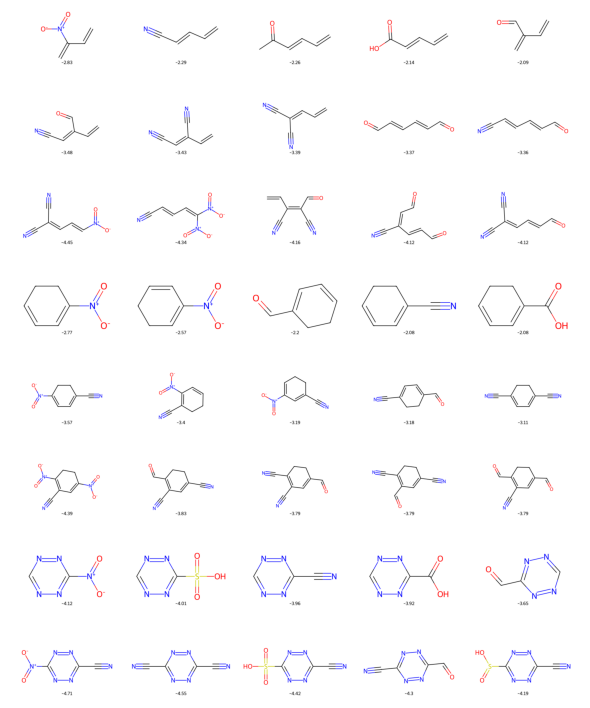

Pearsons correlation: 0.946
R2 score:  0.8460025925093991
RMSE, MAE: 0.2939788976494362 0.2026940433481877


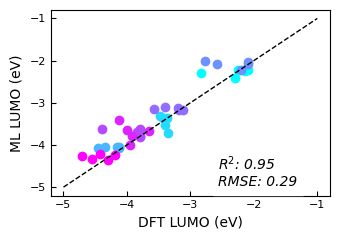

In [97]:
# Read DFT results
df_new_xyz = pd.read_csv('df_new_xyz.csv', index_col=0)
df_new_xyz.set_index('xyz_name', inplace=True)

df_new_dft = pd.read_csv('DFT_new_output.csv', header=None )
df_new_dft.columns = ['LUMO_DFT','Energy_DFT', 'xyz_name']
df_new_dft['xyz_name'] = [ c[4:]+'.xyz' for c in df_new_dft['xyz_name'] ]
df_new_dft.set_index('xyz_name', inplace=True)

df = pd.concat( [df_new_xyz, df_new_dft], axis=1 )

df2=pd.DataFrame()
fig, axs = plt.subplots( len(source_name), 1, figsize=(6,8), tight_layout=True, dpi=100)
for n,s in enumerate(source_name):
    d = df[ df['source']==s ].sort_values(by='LUMO_DFT',ascending=True).head(5)
    img1 = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in d['SMILES'] ], molsPerRow=5, subImgSize=(400, 200), returnPNG=False, 
                                legends=[str(round(e,2)) for e in d['LUMO_DFT']] )
    axs[n].imshow(img1)
    axs[n].axis('off')
    df2=pd.concat( [df2, d], axis=0 )
    display(d)
plt.savefig("new_XYZ_snapshot_finalized.png", dpi=800) 
plt.show()
df = df2.copy()
#mask = [ int(c[-5])<5 for c in df.index]
#df = df[mask]
#display( df )

source_name = list(df.value_counts('source').sort_index(inplace=False, ).index) #ascending=False
customized_label = ['B1','B2','B3','C1','C2','C3','T1','T2']

cmap = plt.get_cmap('cool')
colors = cmap(np.linspace(0, 1, len(source_name) ))
#colors = dict(zip(source_name, colors))
colors = [ colors[ source_name.index(c) ] for c in df['source'] ]
labels = [ customized_label[ source_name.index(c) ] for c in df['source'] ]

corr, _ = stats.pearsonr( df['LUMO_predicted'], df['LUMO_DFT'] )
r2_val = metrics.r2_score(df['LUMO_predicted'], df['LUMO_DFT'])
rmse_val = np.sqrt(metrics.mean_squared_error(df['LUMO_predicted'], df['LUMO_DFT']))    
mae_val = metrics.mean_absolute_error(df['LUMO_predicted'], df['LUMO_DFT'])
print('Pearsons correlation: %.3f' % corr)
print("R2 score: " , r2_val)
print("RMSE, MAE:", rmse_val, mae_val)

fig, axs = plt.subplots(1,1,figsize=(3.5,2.5),tight_layout=True,dpi=100)
for n,(y,x,c,b) in enumerate(zip( df['LUMO_predicted'], df['LUMO_DFT'], colors, labels)):
#im = axs.scatter(x, y, marker='o', c=z, cmap='jet', label='Validating', alpha=0.8, s=10)     
    axs.plot( x,y , 'o', color=c, lw=1, label=b )
axs.plot([-5,-1], [-5,-1], '--', color='k', lw=1)

axs.set_xlabel('DFT LUMO (eV)',fontsize=10) ## input X name
axs.set_ylabel('ML LUMO (eV)',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize=8)

corr, rmse_val = np.round([corr, rmse_val,], 2)
performance = f'R$^2$: {corr}\nRMSE: {rmse_val}'#\nMAE: {mae_val}'
axs.text(0.6,0.05, performance, style='italic', fontsize=10, transform = axs.transAxes, backgroundcolor='white', color='k')

plt.savefig("Compare_DFT_ML_new.png", dpi=800)  
plt.show()



In [95]:
df.to_csv('df_new_selected.csv')
df

,SMILES,INCHI,source,LUMO_predicted,LUMO_DFT,Energy_DFT
xyz_name,,,,,,
pybel_0_1_2.xyz,C=CC(=C)[N+](=O)[O-],"InChI=1S/C4H5NO2/c1-3-4(2)5(6)7/h3H,1-2H2",0_1,-2.29,-2.83,-360.46
pybel_0_1_0.xyz,C=CC=CC#N,"InChI=1S/C5H5N/c1-2-3-4-5-6/h2-4H,1H2",0_1,-2.41,-2.29,-248.20
pybel_0_1_6.xyz,C=CC=CC(C)=O,"InChI=1S/C6H8O/c1-3-4-5-6(2)7/h3-5H,1H2,2H3",0_1,-2.22,-2.26,-308.60
pybel_0_1_3.xyz,C=CC=CC(=O)O,"InChI=1S/C5H6O2/c1-2-3-4-5(6)7/h2-4H,1H2,(H,6,7)",0_1,-2.24,-2.14,-344.54
pybel_0_1_5.xyz,C=CC(=C)C=O,"InChI=1S/C5H6O/c1-3-5(2)4-6/h3-4H,1-2H2",0_1,-2.22,-2.09,-269.28
pybel_0_2_18.xyz,C=CC(C=O)=CC#N,"InChI=1S/C6H5NO/c1-2-6(5-8)3-4-7/h2-3,5H,1H2",0_2,-3.32,-3.48,-361.51
pybel_0_2_15.xyz,C=CC(C#N)=CC#N,"InChI=1S/C6H4N2/c1-2-6(5-8)3-4-7/h2-3H,1H2",0_2,-3.37,-3.43,-340.42
pybel_0_2_12.xyz,C=CC=C(C#N)C#N,"InChI=1S/C6H4N2/c1-2-3-6(4-7)5-8/h2-3H,1H2",0_2,-3.52,-3.39,-340.42
pybel_0_2_14.xyz,O=CC=CC=CC=O,InChI=1S/C6H6O2/c7-5-3-1-2-4-6-8/h1-6H,0_2,-3.37,-3.37,-382.61


,SMILES,INCHI,source,LUMO_predicted,LUMO_DFT,Energy_DFT,err
xyz_name,,,,,,,
pybel_1_3_57.xyz,N#CC1=C([N+](=O)[O-])CCC([N+](=O)[O-])=C1,InChI=1S/C7H5N3O4/c8-4-5-3-6(9(11)12)1-2-7(5)1...,1_3,-3.62,-4.39,-734.62,0.77
pybel_1_1_35.xyz,O=[N+]([O-])C1=CC=CCC1,"InChI=1S/C6H7NO2/c8-7(9)6-4-2-1-3-5-6/h1-2,4H,...",1_1,-2.01,-2.77,-437.89,0.76
pybel_2_1_68.xyz,O=[N+]([O-])c1nncnn1,InChI=1S/C2HN5O2/c8-7(9)2-5-3-1-4-6-2/h1H,2_1,-3.41,-4.12,-500.78,0.71
pybel_0_1_2.xyz,C=CC(=C)[N+](=O)[O-],"InChI=1S/C4H5NO2/c1-3-4(2)5(6)7/h3H,1-2H2",0_1,-2.29,-2.83,-360.46,0.54
pybel_1_1_31.xyz,O=[N+]([O-])C1=CCCC=C1,"InChI=1S/C6H7NO2/c8-7(9)6-4-2-1-3-5-6/h2,4-5H,...",1_1,-2.09,-2.57,-437.88,0.49
pybel_2_2_72.xyz,N#Cc1nnc([N+](=O)[O-])nn1,InChI=1S/C3N6O2/c4-1-2-5-7-3(8-6-2)9(10)11,2_2,-4.26,-4.71,-593.00,0.45
pybel_1_2_43.xyz,N#CC1=CC=C([N+](=O)[O-])CC1,InChI=1S/C7H6N2O2/c8-5-6-1-3-7(4-2-6)9(10)11/h...,1_2,-3.15,-3.57,-530.12,0.41
pybel_0_3_22.xyz,N#CC(C#N)=CC=C[N+](=O)[O-],InChI=1S/C6H3N3O2/c7-4-6(5-8)2-1-3-9(10)11/h1-3H,0_3,-4.08,-4.45,-544.93,0.38
pybel_2_1_64.xyz,O=S(=O)(O)c1nncnn1,"InChI=1S/C2H2N4O3S/c7-10(8,9)2-5-3-1-4-6-2/h1H...",2_1,-3.64,-4.01,-920.11,0.37


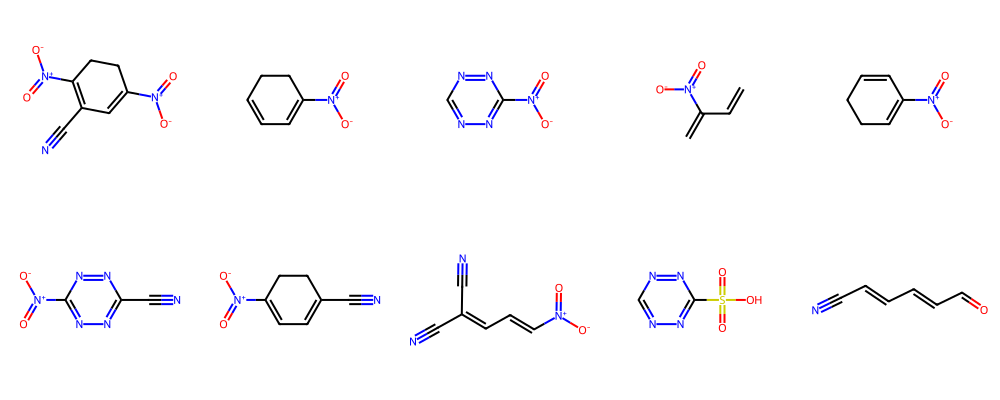

In [96]:
err = df["LUMO_DFT"]-df["LUMO_predicted"]
df['err'] = err.abs() 
df = df.sort_values(by=['err'], ascending=False)

display( df.head(10) )
img1 = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in df.head(10)['SMILES'] ], molsPerRow=5,  )
img1

# NEB analysis

In [1]:
import pandas as pd
import numpy as np
import os

import networkx as nx

from ase.io import read, write
from ase.atoms import Atoms
from itertools import combinations, combinations_with_replacement

# bond list, angle list, dihedral list, nonbond list of an ATOM frame
from ase import neighborlist as ngbls
from ase.geometry.geometry import get_distances_derivatives
from ase.geometry.geometry import get_angles_derivatives
from ase.geometry.geometry import get_dihedrals_derivatives
from ase.geometry.geometry import get_dihedrals

import matplotlib.pyplot as plt

def get_connectivity(at):
    natom = len(at)
    # refresh connectivity 
    cutoffs = [ n for n in ngbls.natural_cutoffs(at, mult=1.01) ]
    #print(cutoffs)
    ngb_list = ngbls.NeighborList(cutoffs, self_interaction=False, bothways=True)
    ngb_list.update(at)
    connect = ngb_list.get_connectivity_matrix(sparse=False)
    return connect

def get_xyz_connect(at):
    natom = len(at)
    # get bond connectivity 
    cutoffs = [ n for n in ngbls.natural_cutoffs(at) ]
    ngb_list = ngbls.NeighborList(cutoffs, self_interaction=False, bothways=True)
    ngb_list.update(at)
    connect = ngb_list.get_connectivity_matrix(sparse=False)
    connect = np.triu(connect,k=0)
    return connect

def generate_graph(at):
    connect = get_xyz_connect(at)
    element = at.get_chemical_symbols()
    
    graph = nx.Graph()
    for n in range(len(at)):
        graph.add_node(n, symbol=element[n])
    for bond in np.argwhere( connect==1 ):
        graph.add_edge(bond[0], bond[1], bond_type=1)

    return graph

def subgraph_finder(graph):
    subgraph = [graph.subgraph(c) for c in nx.connected_components(graph)]
    nodes = [ list(subg.nodes) for subg in subgraph ]
    return nodes

def get_xyz_intermolecular(at, cluster, num=1):
    dist = at.get_all_distances(mic=True, vector=False)
    dist = np.triu(dist,k=0)
    dist_inter = dist[cluster[0],:][:,cluster[1]]
    #np.fill_diagonal(dist,100); #dist[connect==1]=100
    idx = np.argpartition( dist_inter.flatten(), num )[:num]
    min_values = sorted( dist_inter.flatten()[idx] )
    idx = np.array([ np.argwhere(dist==m)[0] for m in min_values ])
    #print(idx)
    #idx[:,1] += np.amin( cluster[1] )  ## This is the index in the original matx
    return idx

In [2]:
df = pd.read_csv('df_new_selected.csv', index_col=0)
xyz = [ os.path.join('selected_xyz','job_'+x) for x in df.index ]
trajs = [ 'traj-c4.xyz','traj-c6.xyz','traj-n4.xyz' ]
#trajs = [ read(t,index=':') for t in trajs ]

In [21]:
# Tetrazine's NEB trajectory
xyz_neb = trajs[2]
xyz_neb = read(xyz_neb, index=':')

# File of output XYZ
xyz_selected = [ x for x in xyz if 'job_pybel_2_' in x ]

# all frames in the NEB traj
for iframe in range( len(xyz_neb) ):
    print( iframe )
    atom1 = xyz_neb[ iframe ]
    pos1 = atom1.get_positions()
    natom1 = len(atom1)
    elements1 = atom1.get_chemical_symbols()
    connect1 = get_connectivity(atom1)
    
    ## Find the two C and connected N atoms in tetrazine
    at_in_complex = []  
    for n in range(natom1):
        ngb = np.argwhere(connect1[n]==1).flatten().tolist()
        if elements1[n]=='N' and len(ngb)==2:
            at_in_complex += ngb
    at_in_complex = sorted( set(at_in_complex) )
    at_C_in_complex = {}
    for n in at_in_complex:
        if elements1[n]=='C':
            ngb = np.argwhere(connect1[n]==1).flatten().tolist()
            ngb_inside = sorted([b for b in ngb if b in at_in_complex ])
            ngb_outside = sorted([b for b in ngb if b not in at_in_complex ])
            at_C_in_complex[n] = [ ngb_inside, ngb_outside ] ## inside N, outside 
    #print( at_C_in_complex )
    ## The C and its H ngb
    base_vec = [ [k, v[1][-1]] for k,v in at_C_in_complex.items() ]
    vec_in_complex = [ pos1[ b[1] ] - pos1[ b[0] ] for b in base_vec ]
    pos_in_complex = [ pos1[ b[1] ] for b in base_vec ]
    #print( base_vec )
    
    ## go over the xyz
    for x in xyz_selected:
        #print( x )
        atom2 = read( x )
        pos2 = atom2.get_positions()
        natom2 = len(atom2)
        elements2 = atom2.get_chemical_symbols()
        connect2 = get_connectivity(atom2)
        
        at_in_diene = [] 
        for n in range(natom2):
            ngb = np.argwhere(connect2[n]==1).flatten().tolist()
            if elements2[n]=='N' and len(ngb)==2:
                at_in_diene += ngb
        at_in_diene = sorted( set(at_in_diene) )
        at_C_in_diene = {}
        for n in at_in_diene:
            if elements2[n]=='C':
                ngb = np.argwhere(connect2[n]==1).flatten().tolist()
                ngb_inside = sorted([b for b in ngb if b in at_in_diene ])
                ngb_outside = sorted([b for b in ngb if b not in at_in_diene ])
                at_C_in_diene[n] = [ ngb_inside, ngb_outside ] ## inside N, outside 
        #print( at_C_in_diene )
        if len(at_C_in_diene)!=2:
            print( at_C_in_diene, x )
        ## The C and its H ngb
        func_vec = [ [k, v[1][-1]] for k,v in at_C_in_diene.items() ]
        #print( func_vec )
    
        graph = generate_graph(atom2)
        for nodes in func_vec:
            graph.remove_edge(nodes[0],nodes[1])
        cluster = subgraph_finder(graph)
        
        # Now move the new diene to the proper position (and orientiation)
        atom_new = atom1.copy()
        del atom_new[ [base_vec[0][1],base_vec[1][1]] ]
        
        for i_func, f in enumerate(func_vec):
            cluster_f = [c for c in cluster if f[1] in c ][0]
            atom3 = atom2[cluster_f]
            #print(f, cluster_f)
            vec_in_diene = pos2[ f[1] ] - pos2[ f[0] ]
            pos_in_diene = pos2[ f[1] ]
            
            # replace in same order?
            if True:
                order = 'same'
            else:
                order = 'reverse'
                i_func = 1-i_func
                
            atom3.rotate(vec_in_diene, vec_in_complex[i_func], center=pos_in_diene)
            atom3.translate( pos_in_complex[i_func] - pos_in_diene )
            atom_new += atom3
            
        fout = f'built-{order}-{iframe}-' + x.split("\\")[-1]
        fout = os.path.join('built-path-n4', fout)
        write(fout, atom_new)

        #pos = nx.spring_layout(graph)
        #nx.draw_networkx(graph, pos, with_labels=True, node_color='lightblue', node_size=400, font_size=8, font_weight='bold', edge_color='gray')
        #nx.draw_networkx_edge_labels(graph, pos)
        #plt.show()
        


0
1
2
3
4
5
6


In [20]:
# cyclo-diene's NEB trajectory
xyz_neb = trajs[1]
xyz_neb = read(xyz_neb, index=':')

# File of output XYZ
xyz_selected = [ x for x in xyz if 'job_pybel_1_' in x ]

# all frames in the NEB traj
for iframe in range( len(xyz_neb) ):
    print( iframe )
    atom1 = xyz_neb[ iframe ]
    pos1 = atom1.get_positions()
    natom1 = len(atom1)
    elements1 = atom1.get_chemical_symbols()
    connect1 = get_connectivity(atom1)
    
    ## Find the four C in diene
    at_in_complex = []  
    #for n in range(natom1):
    #    ngb = np.argwhere(connect1[n]==1).flatten().tolist()
    #    if elements1[n]=='C' and len(ngb)==3:
    #        print( n )
    #        at_in_complex += ngb
    # From above code, we know 47=42-43=44 in the initial state    
    at_in_complex = [47,42,43,44] #sorted( set(at_in_complex) )
    
    at_C_in_complex = {}
    for n in at_in_complex:
        ngb = np.argwhere(connect1[n]==1).flatten().tolist()
        ngb_inside  = sorted([b for b in ngb if elements1[b]!='H' ])
        ngb_outside = sorted([b for b in ngb if elements1[b]=='H' ])
        at_C_in_complex[n] = [ ngb_inside, ngb_outside ] ## inside C, outside H
    #print( at_C_in_complex )
    
    ## The C and its H ngb
    base_vec = [ [k, v[1][0]] for k,v in at_C_in_complex.items() ]
    vec_in_complex = [ pos1[ b[1] ] - pos1[ b[0] ] for b in base_vec ]
    pos_in_complex = [ pos1[ b[1] ] for b in base_vec ]
    #print( base_vec )
    
    ## go over the xyz
    for x in xyz_selected:
        #print( x )
        atom2 = read( x )
        pos2 = atom2.get_positions()
        natom2 = len(atom2)
        elements2 = atom2.get_chemical_symbols()
        connect2 = get_connectivity(atom2)
        
        # first find -CH2-CH2-.
        at_in_diene = [] 
        for n in range(natom2): 
            ngb = np.argwhere(connect2[n]==1).flatten().tolist()
            if elements2[n]=='C' and len(ngb)==4:
                nc = [b for b in ngb if elements2[b]=='C']
                nh = [b for b in ngb if elements2[b]=='H']
                if len(nc)==2 and len(nh)==2:
                    #print( n, ngb )
                    at_in_diene += ngb
        at_in_diene = sorted( set(at_in_diene) ) 
        # second find the two C atoms in diene on edge
        at_in_diene2 = [ n for n in at_in_diene if elements2[n]=='C' and len(np.argwhere(connect2[n]==1).flatten())==3 ]
        #print( at_in_diene2 )
        # third, find the two C atoms in diene in center
        at_in_diene3 = []
        for n in at_in_diene2:
            ngb = np.argwhere(connect2[n]==1).flatten().tolist()
            for b in ngb:
                ngb_b = np.argwhere(connect2[b]==1).flatten().tolist()
                nc = [g for g in ngb_b if elements2[g]=='C']
                nh = [g for g in ngb_b if elements2[g]=='H']
                no = [g for g in ngb_b if elements2[g]=='O']
                if elements2[b]=='C' and len(nc)>=2 and len(ngb_b)==3:
                    at_in_diene3.append( b )
        #print( at_in_diene3 )
        # Final list 
        at_in_diene4 = [at_in_diene2[0]] +at_in_diene3+ [at_in_diene2[1]] 
        if len(at_in_diene4)!=4:
            print( at_in_diene4, x )
        # Get func vectors
        func_vec = []
        for n in at_in_diene4:
            ngb = np.argwhere(connect2[n]==1).flatten().tolist()
            ngb = [ b for b in ngb if b not in at_in_diene and b not in at_in_diene2 and b not in at_in_diene3 ][0]
            func_vec.append( [n, ngb] ) 
        #print( func_vec )
        
        # get graph
        graph = generate_graph(atom2)
        for nodes in func_vec:
            graph.remove_edge(nodes[0],nodes[1])
        cluster = subgraph_finder(graph)
        #print( cluster )
        
        # Now move the new diene to the proper position (and orientiation)
        atom_new = atom1.copy()
        del atom_new[ [b[1] for b in base_vec] ]
        
        for i_func, f in enumerate(func_vec):
            cluster_f = [c for c in cluster if f[1] in c ][0]
            atom3 = atom2[cluster_f]
            vec_in_diene = pos2[ f[1] ] - pos2[ f[0] ]
            pos_in_diene = pos2[ f[1] ]
            # replace in same order?
            if True:
                order = 'same'
            else:
                order = 'reverse'
                i_func = 3-i_func
            atom3.rotate( vec_in_diene, vec_in_complex[i_func], center=pos_in_diene )
            atom3.translate( pos_in_complex[i_func] - pos_in_diene )
            atom_new += atom3
            
        fout = f'built-{order}-{iframe}-' + x.split("\\")[-1]
        fout = os.path.join('built-path-c6', fout)
        write(fout, atom_new)

0
1
2
3
4


In [22]:
# linear-diene's NEB trajectory
xyz_neb = trajs[0]
xyz_neb = read(xyz_neb, index=':')

# File of output XYZ
xyz_selected = [ x for x in xyz if 'job_pybel_0_' in x ]

# all frames in the NEB traj
for iframe in range( len(xyz_neb) ):
    print( iframe )
    atom1 = xyz_neb[ iframe ]
    pos1 = atom1.get_positions()
    natom1 = len(atom1)
    elements1 = atom1.get_chemical_symbols()
    connect1 = get_connectivity(atom1)
    
    ## Find the four C in diene
    at_in_complex = []  
    #for n in range(natom1):
    #    ngb = np.argwhere(connect1[n]==1).flatten().tolist()
    #    ngb_inside  = sorted([b for b in ngb if elements1[b]=='H' ])
    #    ngb_outside = sorted([b for b in ngb if elements1[b]=='H' ])
    #    if elements1[n]=='C' and len(ngb)==3:
    #        print( n, ngb )
    #        at_in_complex += ngb
    # From above code, we know 47=42-43=44 in the initial state    
    at_in_complex = [47,42,43,44] #sorted( set(at_in_complex) )
        
    at_C_in_complex = {}
    for n in at_in_complex:
        ngb = np.argwhere(connect1[n]==1).flatten().tolist()
        ngb_inside  = sorted([b for b in ngb if elements1[b]!='H' ])
        ngb_outside = sorted([b for b in ngb if elements1[b]=='H' ])
        at_C_in_complex[n] = [ ngb_inside, ngb_outside ] ## inside C, outside H
    #print( at_C_in_complex )
    ## The C and its H ngb
    base_vec = [ [k, v[1]] for k,v in at_C_in_complex.items() ]
    vec_in_complex = [ [ pos1[bb] - pos1[b[0]] for bb in b[1] ] for b in base_vec ]
    pos_in_complex = [ [pos1[bb] for bb in b[1]] for b in base_vec ]
    print( 'base_vec', base_vec )
    
    ## go over the xyz
    for x in xyz_selected:
        #print( x )
        atom2 = read( x )
        pos2 = atom2.get_positions()
        natom2 = len(atom2)
        elements2 = atom2.get_chemical_symbols()
        connect2 = get_connectivity(atom2)
        
        # first round of finding diene C.
        at_in_diene = [] 
        for n in range(natom2): 
            ngb = np.argwhere(connect2[n]==1).flatten().tolist()
            if elements2[n]=='C' and len(ngb)==3:
                nc = [b for b in ngb if elements2[b]=='C']
                nh = [b for b in ngb if elements2[b]=='H']
                no = [b for b in ngb if elements2[b]=='O']
                nn = [b for b in ngb if elements2[b]=='N']
                if len(no)>0:  # hard fix for C=O
                    ngb_o = [ len(np.argwhere(connect2[o]==1).flatten().tolist())==1 for o in no ]
                    ngb_o = np.any(ngb_o)
                    if not ngb_o:
                        at_in_diene += [n]
                elif len(nc)>=2:
                    at_in_diene += [n]
                elif len(nh)==2:
                    at_in_diene += [n]
                elif len(nn)==1 and len(nh)==1 and len(nc)==1: # -CH(N)
                    at_in_diene += [n]
                elif len(nn)==2 and len(nc)==1: # -CN(N)
                    at_in_diene += [n]
                    
        at_in_diene = sorted( set(at_in_diene) ) 
        #print(at_in_diene)
        
        # Find the center C
        at_in_diene2 = []
        for n in at_in_diene:
            ngb = np.argwhere(connect2[n]==1).flatten().tolist()
            ngb_b = [b for b in ngb if elements2[b]=='C' and b in at_in_diene]
            if len(ngb_b)==2:
                at_in_diene2.append( n )
        at_in_diene2 = sorted( set(at_in_diene2) )                 
        #print(at_in_diene2)
        
        # Find the edge C
        at_in_diene3 = []
        for n in at_in_diene2:
            ngb = np.argwhere(connect2[n]==1).flatten().tolist()
            ngb = [ b for b in ngb if b in at_in_diene and b not in at_in_diene2 ]
            at_in_diene3 += ngb
        #print(at_in_diene3)
        
        # Final list
        at_in_diene4 = [at_in_diene3[0]] +at_in_diene2+ [at_in_diene3[1]] 
        if len(at_in_diene4)!=4:
            print( at_in_diene4, x )

        # Get func vectors
        func_vec = []
        for n in at_in_diene4:
            ngb = np.argwhere(connect2[n]==1).flatten().tolist()
            ngb = [ b for b in ngb if b not in at_in_diene2 and b not in at_in_diene3 ]
            func_vec.append( [n, ngb] ) 
            #print( n, ngb )
        #print( 'func_vec', func_vec )
                
        # get graph
        graph = generate_graph(atom2)
        for nodes in func_vec:
            for n in nodes[1]:
                graph.remove_edge(nodes[0],n)
        cluster = subgraph_finder(graph)
        #print( 'cluster', cluster )
        
        # Now move the new diene to the proper position (and orientiation)
        atom_new = atom1.copy()
        del atom_new[ [c for b in base_vec for c in b[1]] ]        
        
        for i_func, f in enumerate(func_vec):
            for i_ff, ff in enumerate(f[1]): 
                cluster_f = [c for c in cluster if ff in c ][0]
                atom3 = atom2[cluster_f]
                vec_in_diene = pos2[ ff ] - pos2[ f[0] ]
                pos_in_diene = pos2[ ff ]
                
                # replace in same order?
                if True:
                    order = 'same'
                else:
                    order = 'reverse'
                i_func = 3-i_func
                
                atom3.rotate( vec_in_diene, vec_in_complex[i_func][i_ff], center=pos_in_diene )
                atom3.translate( pos_in_complex[i_func][i_ff] - pos_in_diene )
                atom_new += atom3
            
        fout = f'built-{order}-{iframe}-' + x.split("\\")[-1]
        fout = os.path.join('built-path-c4', fout)
        write(fout, atom_new)

0
base_vec [[47, [46, 48]], [42, [50]], [43, [51]], [44, [45, 49]]]
1
base_vec [[47, [46, 48]], [42, [50]], [43, [51]], [44, [45, 49]]]
2
base_vec [[47, [46, 48]], [42, [50]], [43, [51]], [44, [45, 49]]]
3
base_vec [[47, [46, 48]], [42, [50]], [43, [51]], [44, [45, 49]]]
4
base_vec [[47, [46, 48]], [42, [50]], [43, [51]], [44, [45, 49]]]


# Backup addition scripts

In [ ]:
## If needed, tag parameterization and prediction
func1 = ['CN(C)C', 'CN', 'CO', 'COC', 'CC', 'CC(=O)O', 'CC#N', 'CSC', 'CC=O', 'CS(=O)O','C[S+]([O-])O']  ## Para
img = Draw.MolsToGridImage( [Chem.MolFromSmiles('*'+p[1:]) for p in func1], molsPerRow=11, subImgSize=(400, 300), returnPNG=False )# ,legends=[func[n] for n in range(len(func))] )  
display(img)

func2 = ['CO', 'CN(C)C', 'CN', 'COC',   'CC', 'CC=O', 'CC(=O)O', 'CC#N','CSC', 'CS(=O)O','C[S+]([O-])O']  ## Predi
img = Draw.MolsToGridImage( [Chem.MolFromSmiles('*'+p[1:]) for p in func2], molsPerRow=11, subImgSize=(400, 300), returnPNG=False )# ,legends=[func[n] for n in range(len(func))] )  
display(img)

func3 = [ f for f in func2 if f not in func1 ]
if len(func3)>0:
    img = Draw.MolsToGridImage( [Chem.MolFromSmiles('*'+p[1:]) for p in func3], molsPerRow=11, subImgSize=(400, 300), returnPNG=False )# ,legends=[func[n] for n in range(len(func))] )  
    display(img )

display(func1, func2, func3)

In [ ]:
from rdkit.Chem.MolStandardize import rdMolStandardize
uncharger = rdMolStandardize.Uncharger() 

def has_substructure(smi, sub_structs):
    mol = Chem.MolFromSmiles(smi)
    Chem.Kekulize(mol)
    if mol is None:
        match = False
    else:
        match = False
        for s in sub_structs:
            m = Chem.MolFromSmiles(s)
            Chem.Kekulize(m)
            match = np.all([ mol.HasSubstructMatch( m ), m.HasSubstructMatch( mol ) ])
            if match:
                break
    return match

def know_fragment(molecule_smile, pattern_smile, list_keep_smile):
    m1 =  Chem.AddHs(Chem.MolFromSmiles(molecule_smile))
    m2 =  Chem.MolFromSmiles(pattern_smile)
    #display(m1)

    rm = AllChem.DeleteSubstructs(m1, m2)
    fragment_smile = Chem.MolToSmiles(rm)
    
    fragment_smile = [ f.replace('[H]','F') for f in fragment_smile.split('.') if f!='[HH]' ]
    #fragment_smile = [ f.replace('[O-][S+]','O=S') for f in fragment_smile ] 
    #fragment_smile = [ f.replace('[S+][O-]','S=O') for f in fragment_smile ] 
    #print(fragment_smile)
    
    list_keep_smile = [ Chem.MolFromSmiles(s) for s in list_keep_smile ]
    
    if_bad = False
    for f in fragment_smile:  
        mol = Chem.AddHs(Chem.MolFromSmiles(f))
        smi = Chem.MolToSmiles( mol, canonical=True, isomericSmiles=True)#.replace('[H]','Br')

        mol=Chem.MolFromSmiles(smi)
        Chem.Kekulize(mol)
        smi = Chem.MolToSmiles( mol, canonical=True, isomericSmiles=True)
        #print( f, smi )
        
        match = [ np.all([ mol.HasSubstructMatch(m_in_list), m_in_list.HasSubstructMatch(mol) ]) for m_in_list in list_keep_smile ]
        #print( match )
        match = np.any(match) # True if it finds a match to patterns, False if it has no match.
        
        if not match:
        #if smi not in list_keep_smile:
            if_bad = True
            break
    
    return if_bad


frag_to_keep = [ ]
for s in func1:
    m = Chem.AddHs( Chem.MolFromSmiles('Br'+s[1:]) )
    smi = Chem.MolToSmiles( m, canonical=True, isomericSmiles=True)
    smi = smi.replace('[H]','F').replace('(Br)','').replace('Br','')
    m = Chem.MolFromSmiles( smi )
    Chem.Kekulize(m)
    #m = Chem.RemoveHs(m, sanitize=False, updateExplicitCount=True)
    smi = Chem.MolToSmiles( m, canonical=True, isomericSmiles=True)
    frag_to_keep.append( smi )

print( frag_to_keep )
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in frag_to_keep], molsPerRow=11, subImgSize=(400, 300), returnPNG=False )# ,legends=[func[n] for n in range(len(func))] )  
display( img )

smi1 = '[H]O/C([O-])=C(C#N)\C([H])=C(/[H])C([H])=S(=O)=[O+][H]'
smi2 = 'C=CC=C'
#display( Chem.MolFromSmiles(smi1) )
#results = know_fragment(smi1, smi2, frag_to_keep)

In [ ]:
frag_to_new = [ ]
for s in func3:
    m = Chem.AddHs( Chem.MolFromSmiles('Br'+s[1:]) )
    smi = Chem.MolToSmiles( m, canonical=True, isomericSmiles=True)
    smi = smi.replace('[H]','F').replace('(Br)','').replace('Br','')
    m = Chem.MolFromSmiles( smi )
    Chem.Kekulize(m)
    #m = Chem.RemoveHs(m, sanitize=False, updateExplicitCount=True)
    smi = Chem.MolToSmiles( m, canonical=True, isomericSmiles=True)
    frag_to_new.append( smi )

print( frag_to_new )
if len(frag_to_new)>0:
    img = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in frag_to_new], molsPerRow=11, subImgSize=(400, 300), returnPNG=False )# ,legends=[func[n] for n in range(len(func))] )  
    display( img )

In [ ]:

tag = []
for n, (smi, d, t) in enumerate(zip(df_pnl.index,df_pnl['diene_class'],df_pnl['diene_type'])):
    if n%1000==0:
        print('Working on ',n)
    if d=='C4':
        result = know_fragment(smi, 'C=CC=C', frag_to_keep)
    elif d=='C6':
        result = know_fragment(smi, 'C1=CC=CCC1', frag_to_keep)
    elif d=='N4':
        result = know_fragment(smi, 'C1=NN=CN=N1', frag_to_keep)
    else:
        result = 'Issue 1'
        print(smi)

    if result:
        if d=='C4':
            result2 = know_fragment(smi, 'C=CC=C', frag_to_new)
        elif d=='C6':
            result2 = know_fragment(smi, 'C1=CC=CCC1', frag_to_new)
        elif d=='N4':
            result2 = know_fragment(smi, 'C1=NN=CN=N1', frag_to_new)
        else:
            result2 = 'Issue 2'
        
        if result2:
            tag.append( 'hybrid' )
        else:
            tag.append( 'prediction' )
    else:
        tag.append( 'parameterization' )
"""    
tag = []
for n, (smi, d, t) in enumerate(zip(df_pnl.index,df_pnl['diene_class'],df_pnl['diene_type'])):
    if 'three' in t:
        tag.append( 'prediction' )
    else:
        tag.append( 'parameterization' )
"""

# Add tag
df_pnl['tag'] = tag
df_pnl_unknown = df_pnl[ df_pnl['tag']=='prediction' ]
df_pnl_mixed = df_pnl[ df_pnl['tag']=='hybrid' ]
df_pnl = df_pnl[ df_pnl['tag']=='parameterization' ]
display(df_pnl, df_pnl_mixed, df_pnl_unknown)